In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
def conv_block(inputs, num_filter):
    x = layers.Conv3D(num_filter, (3, 3,3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv3D(num_filter, (3, 3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    return x

In [3]:
def encoder_block(inputs,num_filter):
    x = conv_block(inputs, num_filter)
    p = layers.MaxPool3D((2, 2,2))(x)
    return x,p

In [4]:
def decoder_block(inputs, skip, num_filters):
    x = layers.Conv3DTranspose(num_filters, (2, 2,2), strides=(2, 2,2), padding='same')(inputs)
    x = layers.concatenate([x, skip])
    x = conv_block(x, num_filters)
    return x

In [5]:
def build_unet(input_shape):
    inputs = layers.Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    #s4, p4 = encoder_block(p3, 512)

    """ Bridge """
    #b1 = conv_block(p4, 1024)
    b1 = conv_block(p3, 512)

    """ Decoder """

    #d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(b1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")

    return model

In [6]:
input_shape = (32,32,32, 1)
model = build_unet(input_shape)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 32,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 32, 32, 32,   1792        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32,   256        ['conv3d[0][0]']                 
 alization)                     64)                                                           

In [7]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
precision = tf.keras.metrics.Precision(
    thresholds=0.5)
recall = tf.keras.metrics.Recall(
    thresholds=0.5)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[precision,recall])

data

In [8]:
# datasets for tf
from data_preprocessing_3d import get_dataset_large

batch_size = 32
dataset = get_dataset_large("data/LITS_Challenge/LITS_3D_32_new_train/"
)
dataset = dataset.shuffle(5000,reshuffle_each_iteration=True).batch(batch_size)
valid_dataset = get_dataset_large("data/LITS_Challenge/LITS_3D_32_new_valid/"
)
valid_dataset = valid_dataset.batch(
    batch_size
)  # .shuffle(1000,  reshuffle_each_iteration=True)

for sample in dataset.take(1):
    print(sample[0].shape)
    print(sample[1].shape)
for sample in valid_dataset.take(1):
    print(sample[0].shape)
    print(sample[1].shape)


['data\\LITS_Challenge\\LITS_3D_32_new_train\\images0.tfrecords', 'data\\LITS_Challenge\\LITS_3D_32_new_train\\images1.tfrecords', 'data\\LITS_Challenge\\LITS_3D_32_new_train\\images10.tfrecords', 'data\\LITS_Challenge\\LITS_3D_32_new_train\\images11.tfrecords', 'data\\LITS_Challenge\\LITS_3D_32_new_train\\images12.tfrecords', 'data\\LITS_Challenge\\LITS_3D_32_new_train\\images13.tfrecords', 'data\\LITS_Challenge\\LITS_3D_32_new_train\\images14.tfrecords', 'data\\LITS_Challenge\\LITS_3D_32_new_train\\images15.tfrecords', 'data\\LITS_Challenge\\LITS_3D_32_new_train\\images16.tfrecords', 'data\\LITS_Challenge\\LITS_3D_32_new_train\\images17.tfrecords', 'data\\LITS_Challenge\\LITS_3D_32_new_train\\images18.tfrecords', 'data\\LITS_Challenge\\LITS_3D_32_new_train\\images19.tfrecords', 'data\\LITS_Challenge\\LITS_3D_32_new_train\\images2.tfrecords', 'data\\LITS_Challenge\\LITS_3D_32_new_train\\images20.tfrecords', 'data\\LITS_Challenge\\LITS_3D_32_new_train\\images21.tfrecords', 'data\\LITS_

fit?

In [9]:
# Results
# reading checkpoint if needen
#
import datetime
#################################
from clearml import Task
task = Task.init(project_name='master_3D', task_name='model_yt_lesions')
# add tensorboard
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TerminateOnNaN,
)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# training
callbacks = [
    # EarlyStopping(patience=10, verbose=1),
    #ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.0000001, verbose=1),
    ModelCheckpoint(
        "models\\new_yt_3D_lesion\\{epoch:02d}-{val_loss:.4f}.hdf5",
        verbose=1,
        save_best_only=False,
        save_weights_only=False,
    ),
    TerminateOnNaN(),
    tensorboard_callback
]
epochs=10

history = model.fit(
    dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    initial_epoch=0,
)

ClearML Task: created new task id=b921e0e7b54841e0a728f3bc69b1b05d
2023-10-09 13:00:56,107 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/a5ba0abecb204862954072a9a9f30f38/experiments/b921e0e7b54841e0a728f3bc69b1b05d/output/log
Epoch 1/10
   1157/Unknown - 1485s 1s/step - loss: 0.2724 - precision: 0.8533 - recall: 0.8487
Epoch 1: saving model to models\new_yt_3D_lesion\01-0.4283.hdf5
1157/1157 [==============================] - 1581s 1s/step - loss: 0.2724 - precision: 0.8533 - recall: 0.8487 - val_loss: 0.4283 - val_precision: 0.8220 - val_recall: 0.7326
Epoch 2/10
1157/1157 [==============================] - ETA: 0s - loss: 0.2020 - precision: 0.8952 - recall: 0.8898
Epoch 2: saving model to models\new_yt_3D_lesion\02-0.5082.hdf5
1157/1157 [==============================] - 830s 715ms/step - loss: 0.2020 - precision: 0.8952 - recall: 0.8898 - val_loss: 0.5082 - val_precision: 0.7942 - val_recall: 0.8040
Epoch 3/10


In [10]:
from matplotlib import pyplot as plt

In [14]:
model.load_weights("models\\new_yt_3D_lesion\\08-0.5206.hdf5")

431719.0
1/1 [==============================] - 0s 22ms/step


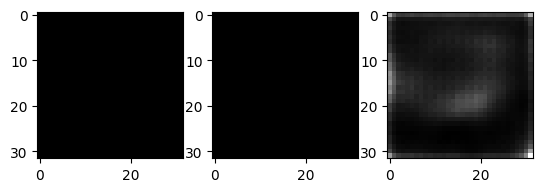

449950.0
1/1 [==============================] - 0s 22ms/step


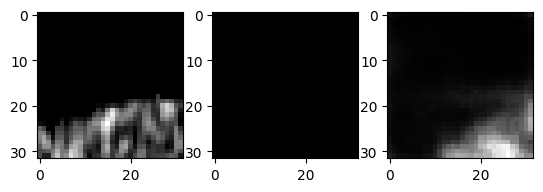

444479.0
1/1 [==============================] - 0s 20ms/step


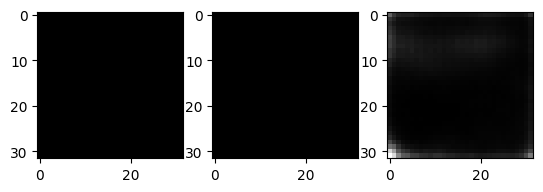

448737.0
1/1 [==============================] - 0s 21ms/step


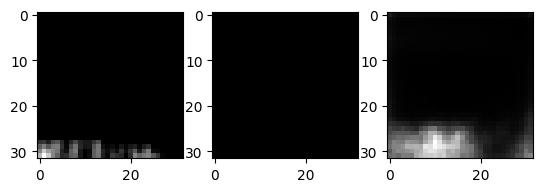

474274.0
1/1 [==============================] - 0s 20ms/step


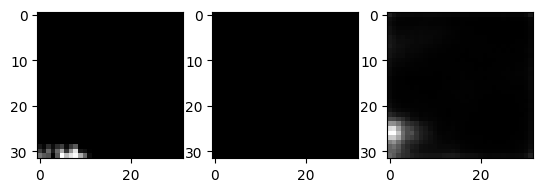

520660.0
1/1 [==============================] - 0s 21ms/step


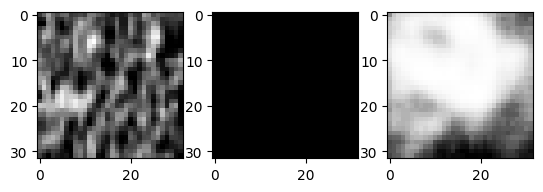

440844.0
1/1 [==============================] - 0s 22ms/step


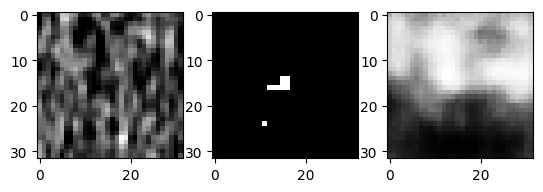

506425.0
1/1 [==============================] - 0s 21ms/step


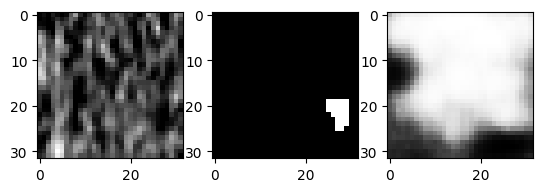

384536.0
1/1 [==============================] - 0s 21ms/step


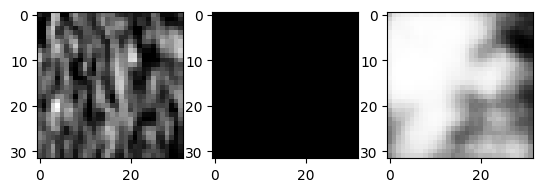

308991.0
1/1 [==============================] - 0s 19ms/step


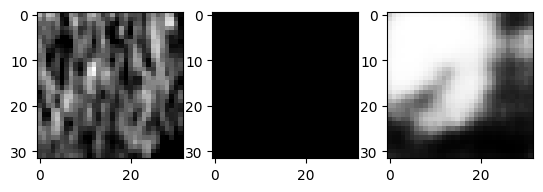

308510.0
1/1 [==============================] - 0s 24ms/step


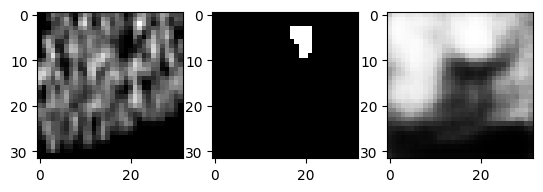

304209.0
1/1 [==============================] - 0s 21ms/step


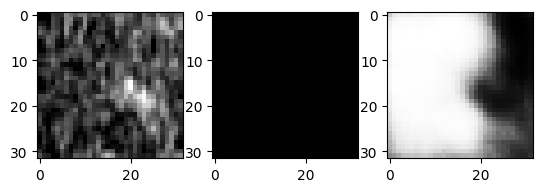

284658.0
1/1 [==============================] - 0s 19ms/step


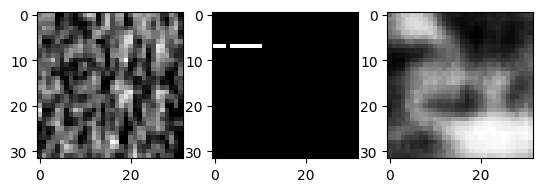

300842.0
1/1 [==============================] - 0s 19ms/step


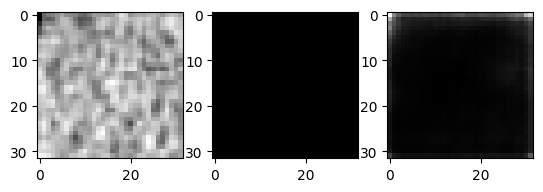

390504.0
1/1 [==============================] - 0s 20ms/step


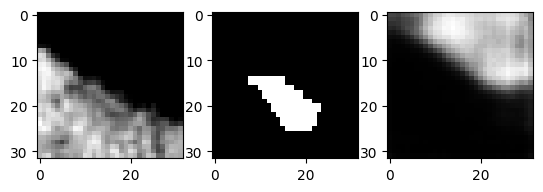

467238.0
1/1 [==============================] - 0s 20ms/step


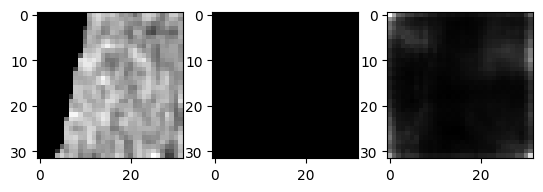

475025.0
1/1 [==============================] - 0s 21ms/step


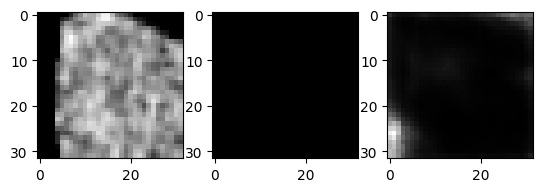

474431.0
1/1 [==============================] - 0s 21ms/step


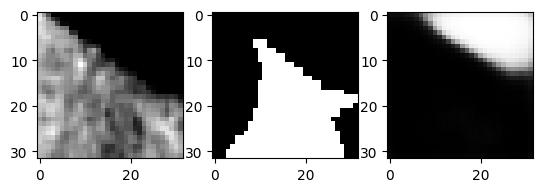

496275.0
1/1 [==============================] - 0s 21ms/step


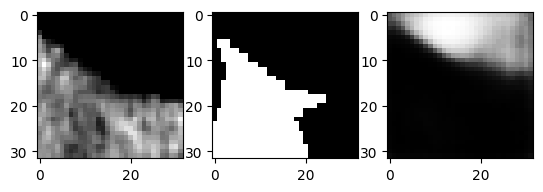

401970.0
1/1 [==============================] - 0s 18ms/step


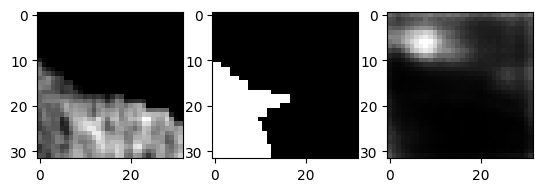

358034.0
1/1 [==============================] - 0s 22ms/step


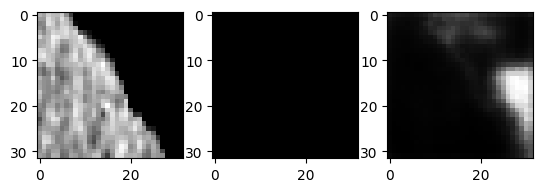

393097.0
1/1 [==============================] - 0s 22ms/step


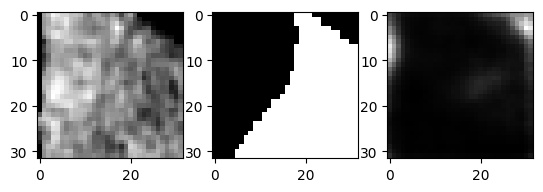

365314.0
1/1 [==============================] - 0s 20ms/step


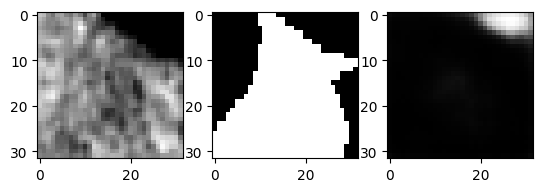

360061.0
1/1 [==============================] - 0s 19ms/step


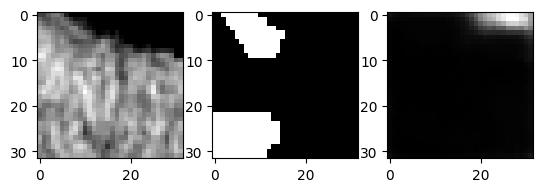

370098.0
1/1 [==============================] - 0s 20ms/step


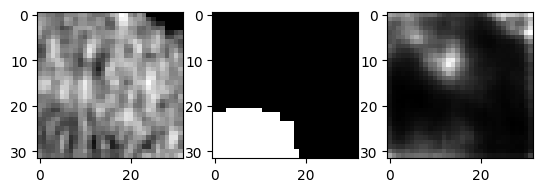

366541.0
1/1 [==============================] - 0s 24ms/step


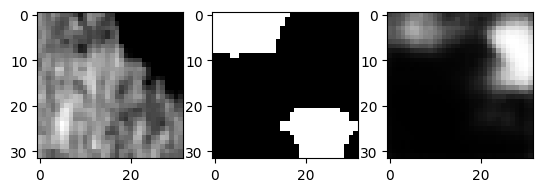

325129.0
1/1 [==============================] - 0s 19ms/step


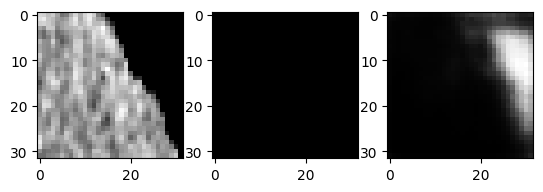

389281.0
1/1 [==============================] - 0s 20ms/step


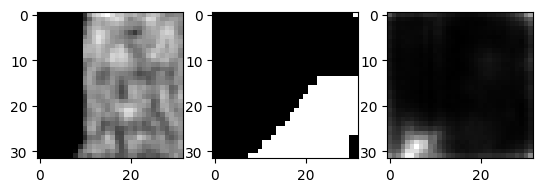

357662.0
1/1 [==============================] - 0s 20ms/step


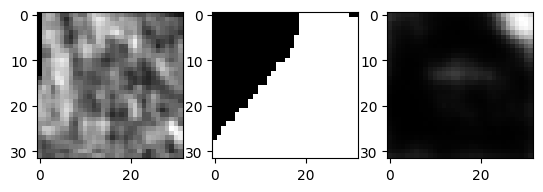

365554.0
1/1 [==============================] - 0s 20ms/step


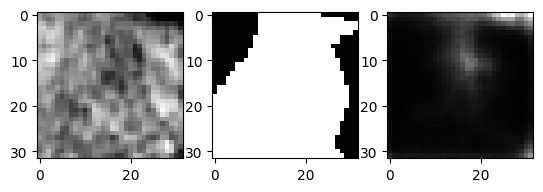

367499.0
1/1 [==============================] - 0s 19ms/step


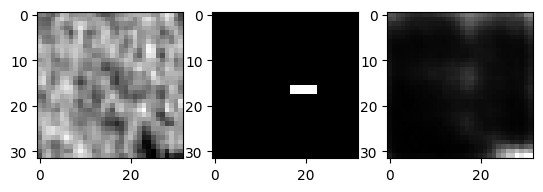

316936.0
1/1 [==============================] - 0s 21ms/step


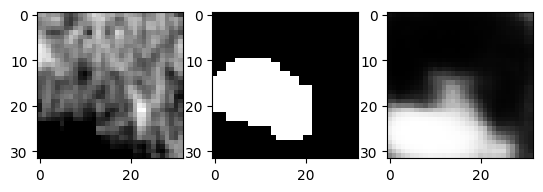

275491.0
1/1 [==============================] - 0s 21ms/step


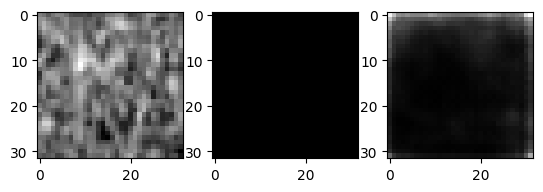

294280.0
1/1 [==============================] - 0s 19ms/step


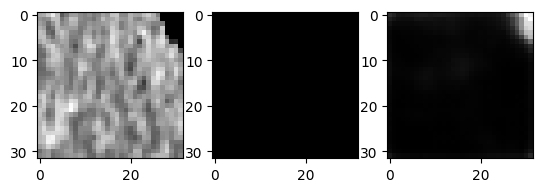

371165.0
1/1 [==============================] - 0s 20ms/step


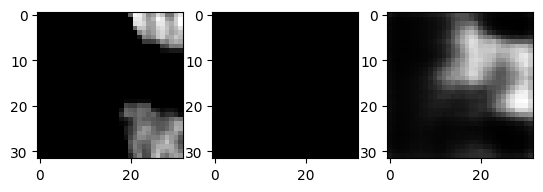

412000.0
1/1 [==============================] - 0s 19ms/step


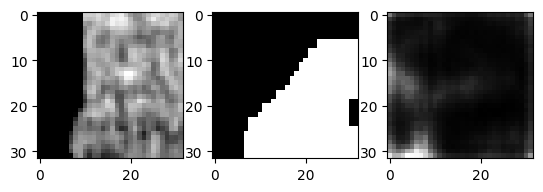

461138.0
1/1 [==============================] - 0s 21ms/step


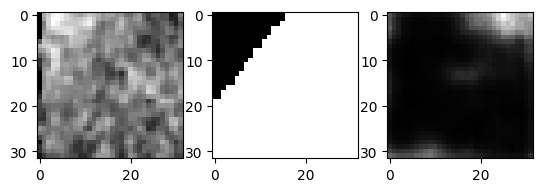

523238.0
1/1 [==============================] - 0s 20ms/step


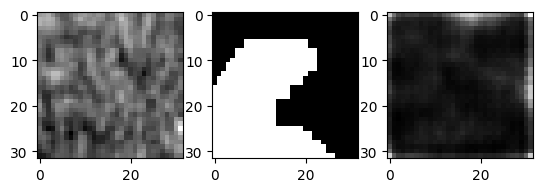

455932.0
1/1 [==============================] - 0s 25ms/step


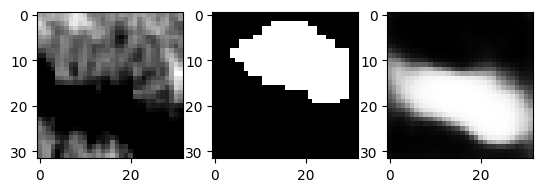

404728.0
1/1 [==============================] - 0s 21ms/step


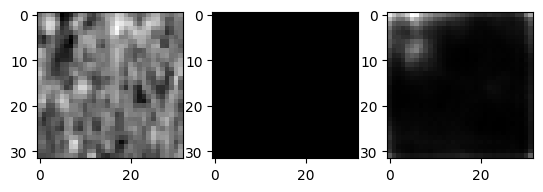

424942.0
1/1 [==============================] - 0s 21ms/step


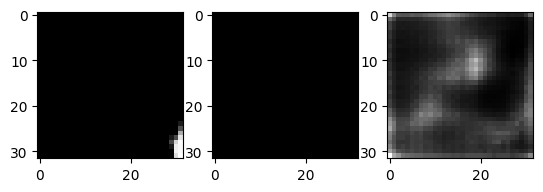

359633.0
1/1 [==============================] - 0s 20ms/step


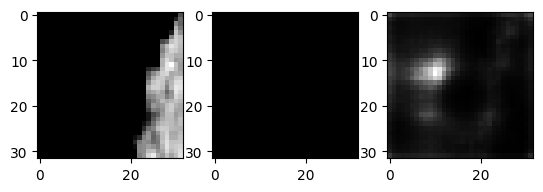

347388.0
1/1 [==============================] - 0s 20ms/step


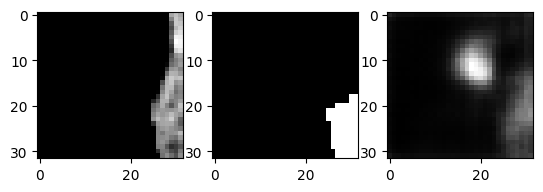

444962.0
1/1 [==============================] - 0s 21ms/step


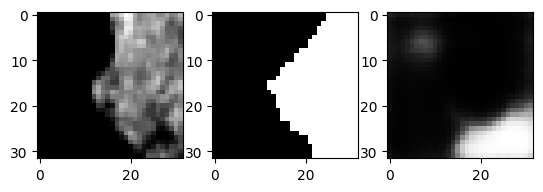

456412.0
1/1 [==============================] - 0s 21ms/step


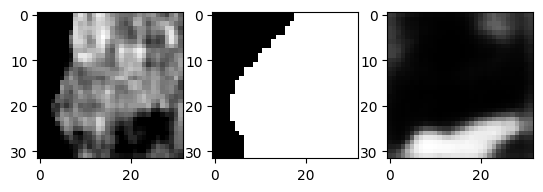

421920.0
1/1 [==============================] - 0s 20ms/step


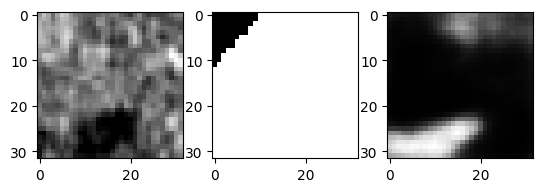

334808.0
1/1 [==============================] - 0s 19ms/step


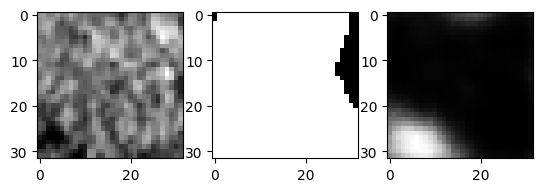

338120.0
1/1 [==============================] - 0s 19ms/step


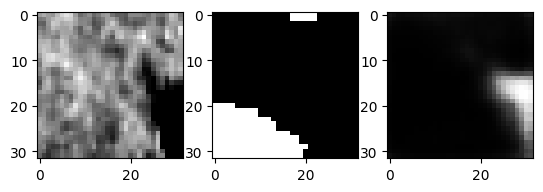

334251.0
1/1 [==============================] - 0s 21ms/step


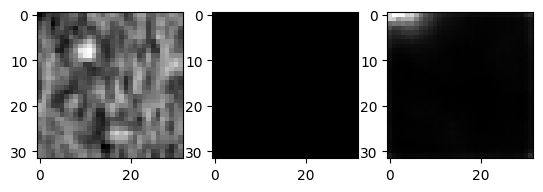

320425.0
1/1 [==============================] - 0s 19ms/step


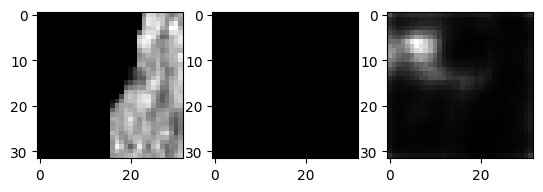

239531.0
1/1 [==============================] - 0s 21ms/step


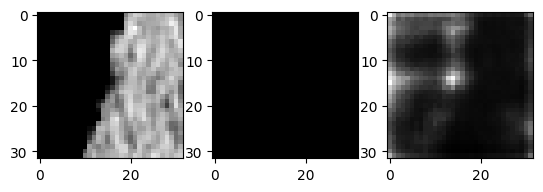

274585.0
1/1 [==============================] - 0s 20ms/step


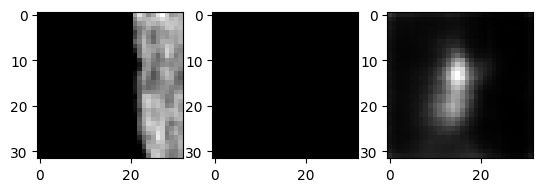

327011.0
1/1 [==============================] - 0s 19ms/step


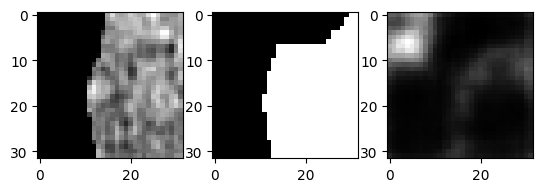

411295.0
1/1 [==============================] - 0s 20ms/step


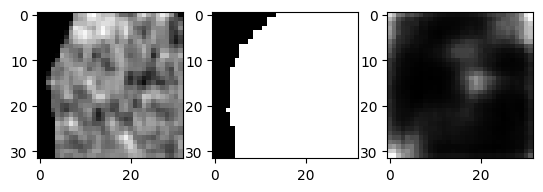

436872.0
1/1 [==============================] - 0s 20ms/step


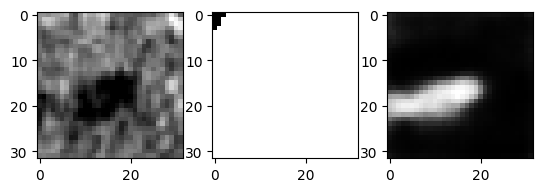

407324.0
1/1 [==============================] - 0s 19ms/step


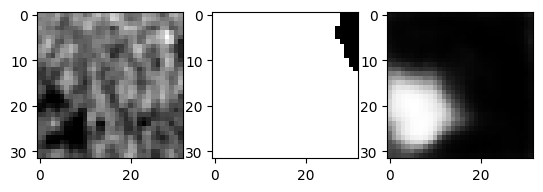

357387.0
1/1 [==============================] - 0s 20ms/step


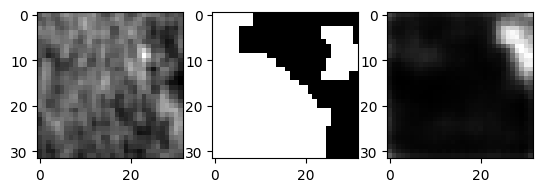

383404.0
1/1 [==============================] - 0s 20ms/step


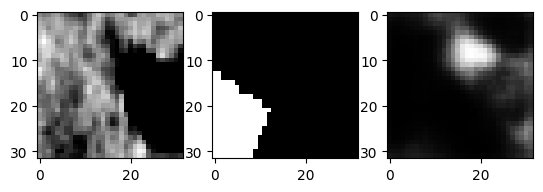

380239.0
1/1 [==============================] - 0s 22ms/step


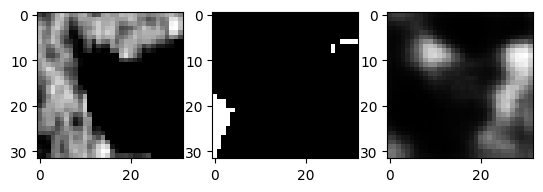

388466.0
1/1 [==============================] - 0s 19ms/step


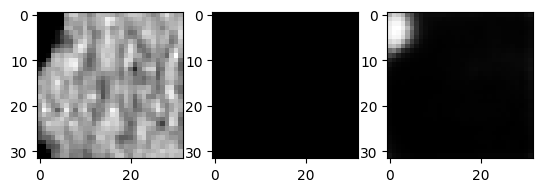

441619.0
1/1 [==============================] - 0s 19ms/step


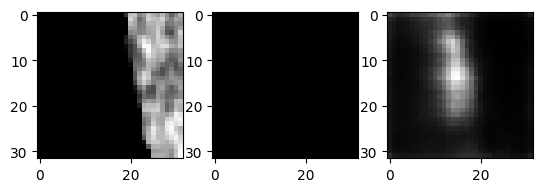

529760.0
1/1 [==============================] - 0s 19ms/step


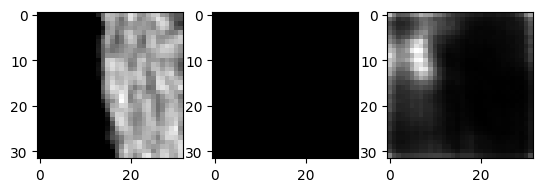

534239.0
1/1 [==============================] - 0s 20ms/step


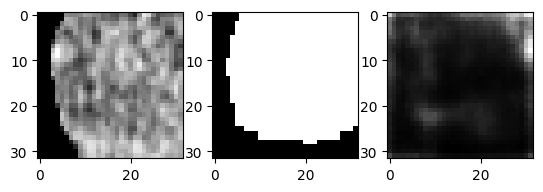

491786.0
1/1 [==============================] - 0s 21ms/step


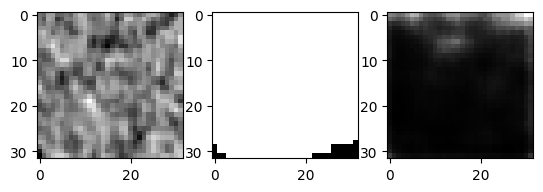

443987.0
1/1 [==============================] - 0s 20ms/step


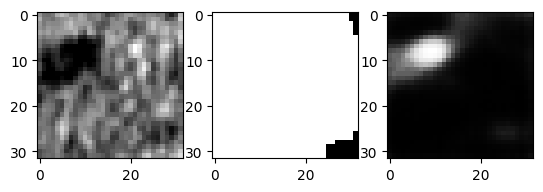

371222.0
1/1 [==============================] - 0s 20ms/step


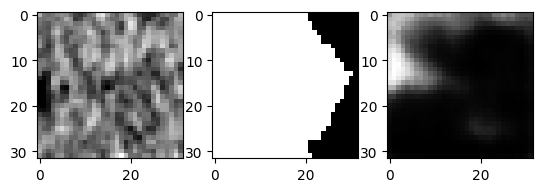

379162.0
1/1 [==============================] - 0s 19ms/step


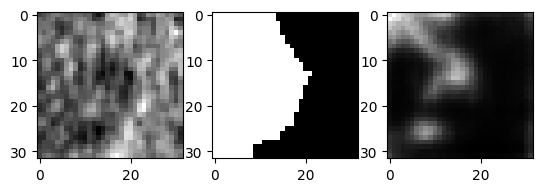

457282.0
1/1 [==============================] - 0s 25ms/step


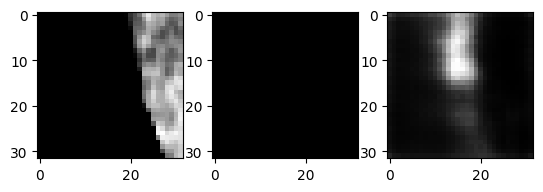

493635.0
1/1 [==============================] - 0s 20ms/step


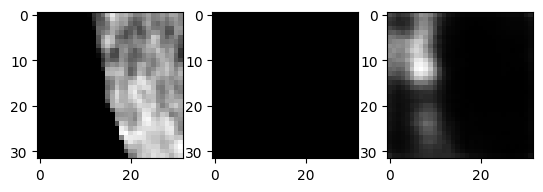

501597.0
1/1 [==============================] - 0s 20ms/step


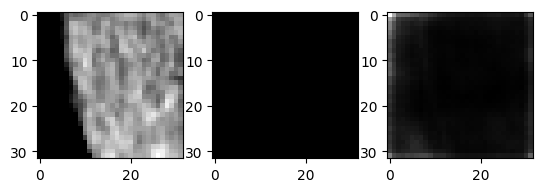

407397.0
1/1 [==============================] - 0s 19ms/step


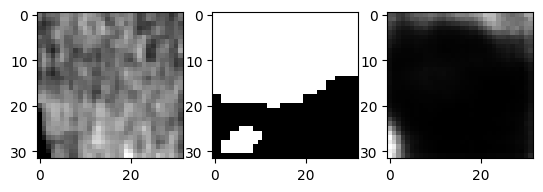

341112.0
1/1 [==============================] - 0s 20ms/step


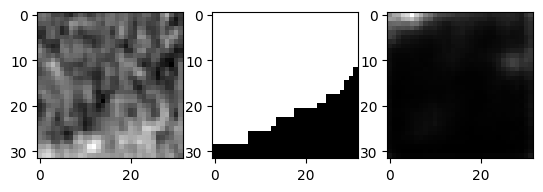

372600.0
1/1 [==============================] - 0s 20ms/step


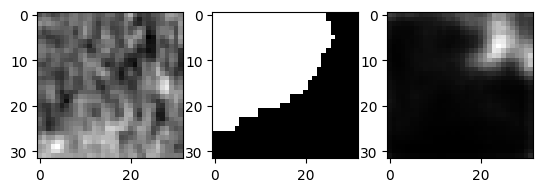

330796.0
1/1 [==============================] - 0s 21ms/step


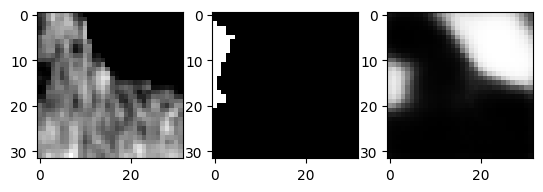

370918.0
1/1 [==============================] - 0s 21ms/step


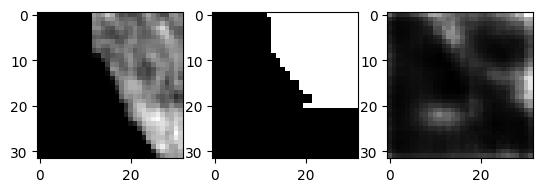

463704.0
1/1 [==============================] - 0s 21ms/step


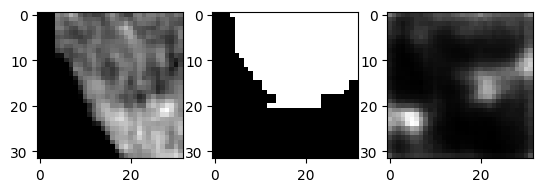

398238.0
1/1 [==============================] - 0s 22ms/step


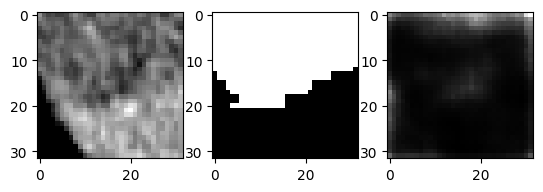

426678.0
1/1 [==============================] - 0s 23ms/step


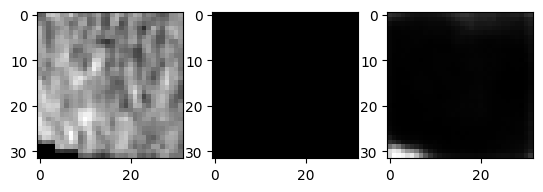

374904.0
1/1 [==============================] - 0s 23ms/step


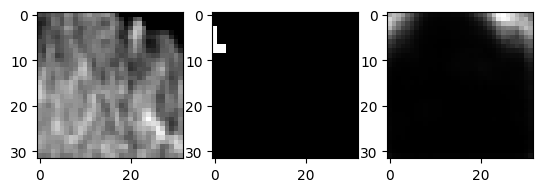

429096.0
1/1 [==============================] - 0s 30ms/step


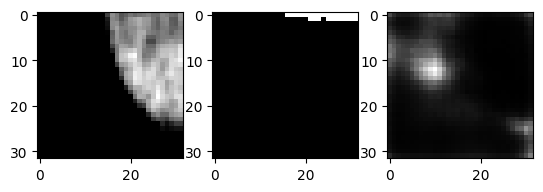

388626.0
1/1 [==============================] - 0s 20ms/step


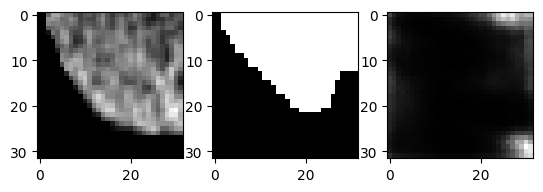

384155.0
1/1 [==============================] - 0s 20ms/step


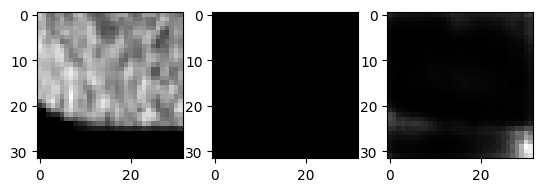

369661.0
1/1 [==============================] - 0s 22ms/step


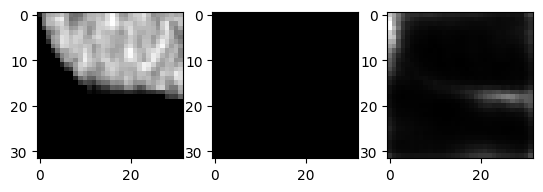

392171.0
1/1 [==============================] - 0s 20ms/step


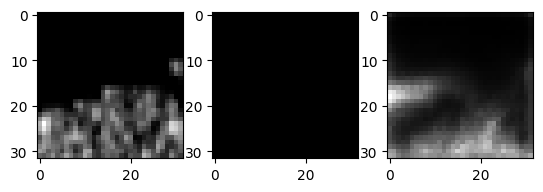

382470.0
1/1 [==============================] - 0s 20ms/step


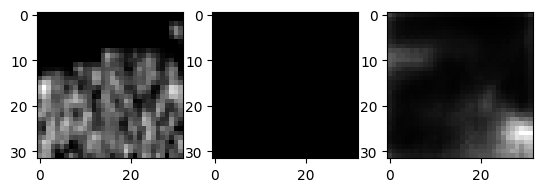

468239.0
1/1 [==============================] - 0s 20ms/step


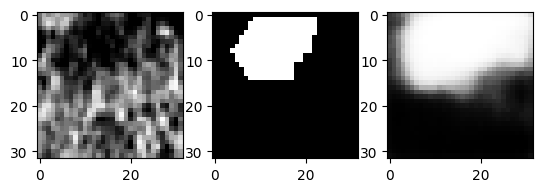

529055.0
1/1 [==============================] - 0s 20ms/step


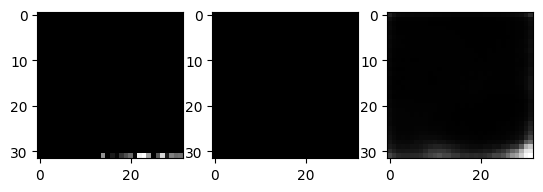

414540.0
1/1 [==============================] - 0s 20ms/step


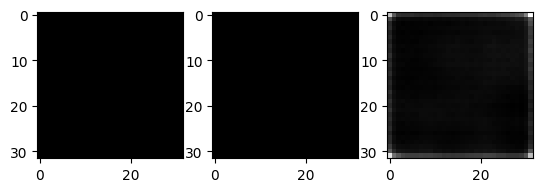

471201.0
1/1 [==============================] - 0s 21ms/step


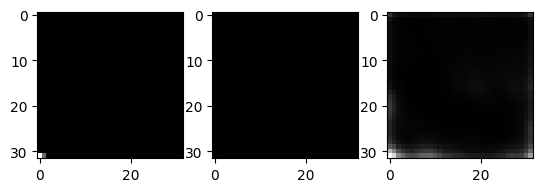

374745.0
1/1 [==============================] - 0s 20ms/step


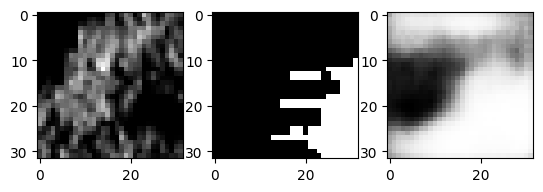

357018.0
1/1 [==============================] - 0s 22ms/step


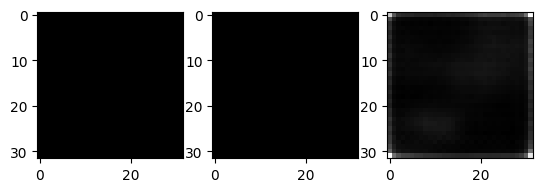

367951.0
1/1 [==============================] - 0s 21ms/step


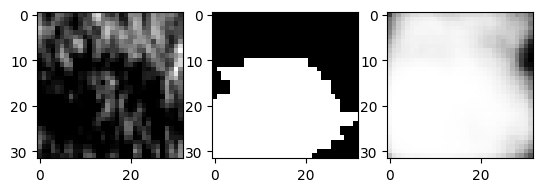

259647.0
1/1 [==============================] - 0s 21ms/step


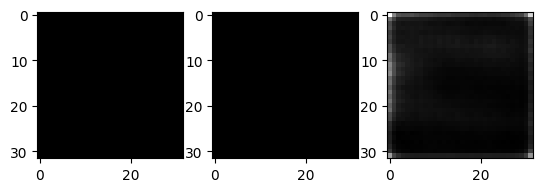

328405.0
1/1 [==============================] - 0s 20ms/step


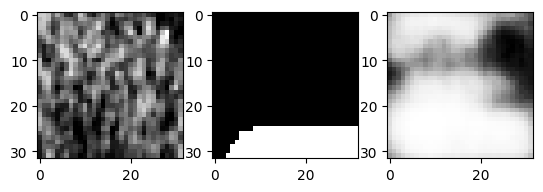

315681.0
1/1 [==============================] - 0s 20ms/step


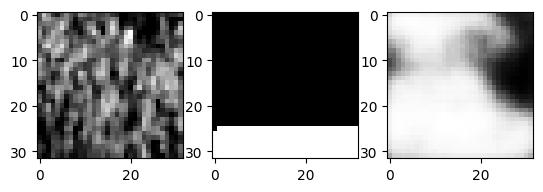

354296.0
1/1 [==============================] - 0s 20ms/step


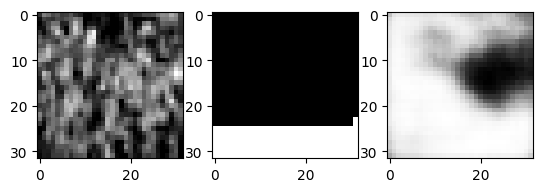

310158.0
1/1 [==============================] - 0s 31ms/step


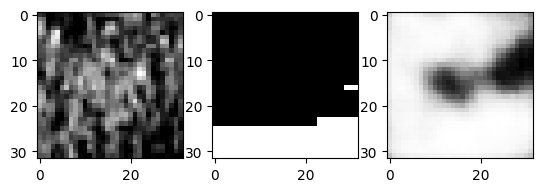

407815.0
1/1 [==============================] - 0s 20ms/step


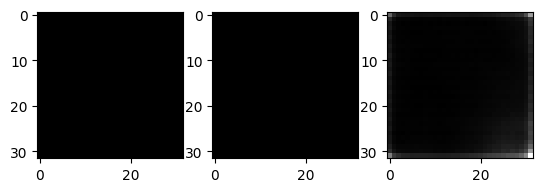

391435.0
1/1 [==============================] - 0s 20ms/step


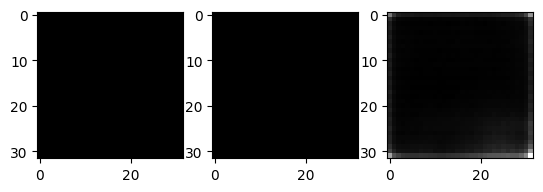

468878.0
1/1 [==============================] - 0s 19ms/step


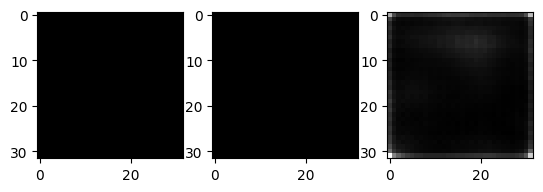

371378.0
1/1 [==============================] - 0s 19ms/step


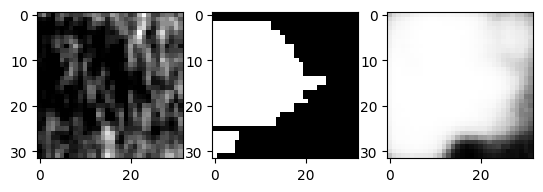

407805.0
1/1 [==============================] - 0s 21ms/step


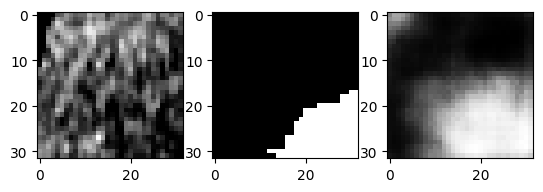

512426.0
1/1 [==============================] - 0s 22ms/step


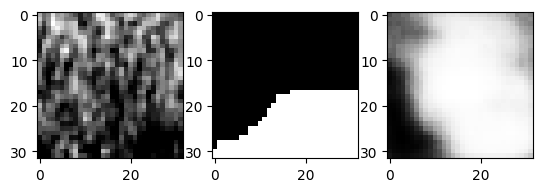

528823.0
1/1 [==============================] - 0s 25ms/step


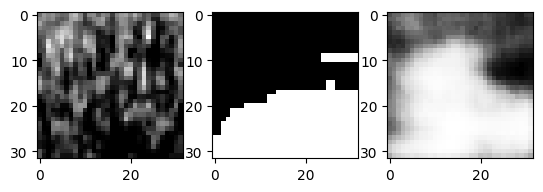

537924.0
1/1 [==============================] - 0s 20ms/step


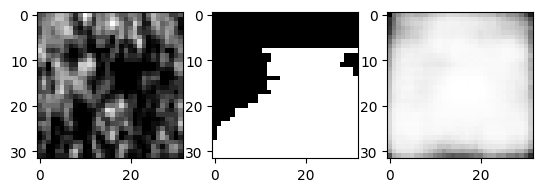

532486.0
1/1 [==============================] - 0s 20ms/step


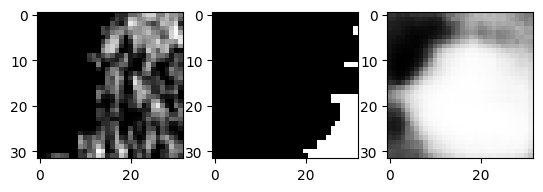

480314.0
1/1 [==============================] - 0s 21ms/step


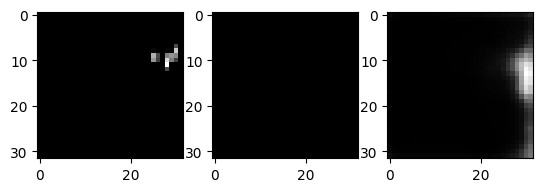

483967.0
1/1 [==============================] - 0s 21ms/step


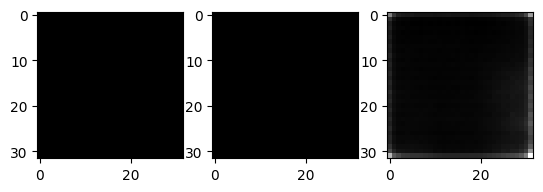

495123.0
1/1 [==============================] - 0s 20ms/step


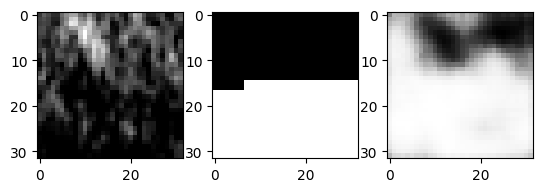

373574.0
1/1 [==============================] - 0s 21ms/step


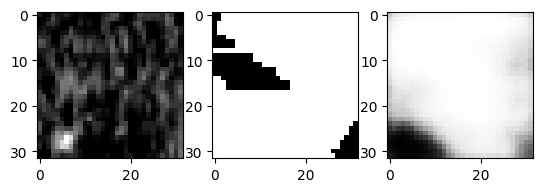

487180.0
1/1 [==============================] - 0s 20ms/step


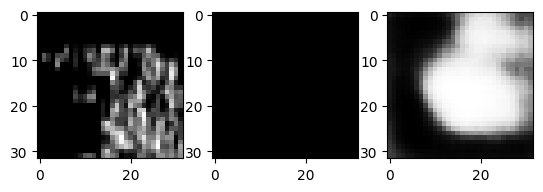

357687.0
1/1 [==============================] - 0s 21ms/step


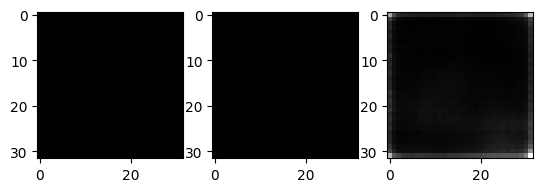

294632.0
1/1 [==============================] - 0s 21ms/step


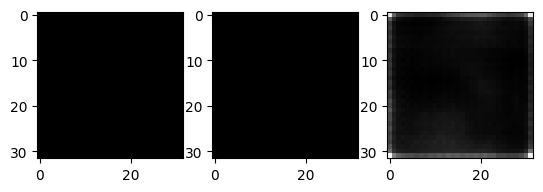

305030.0
1/1 [==============================] - 0s 20ms/step


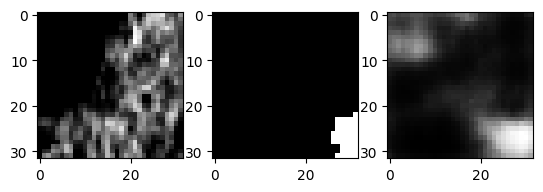

274827.0
1/1 [==============================] - 0s 21ms/step


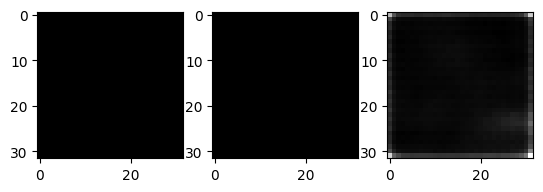

302782.0
1/1 [==============================] - 0s 21ms/step


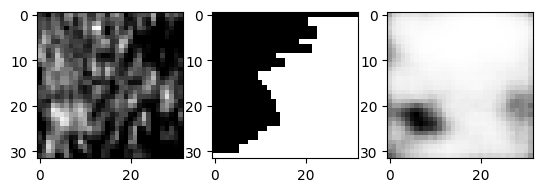

350645.0
1/1 [==============================] - 0s 27ms/step


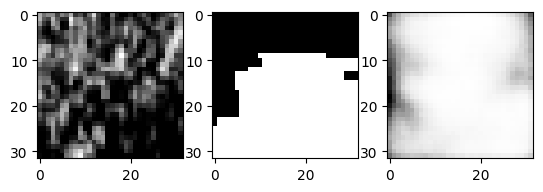

396034.0
1/1 [==============================] - 0s 23ms/step


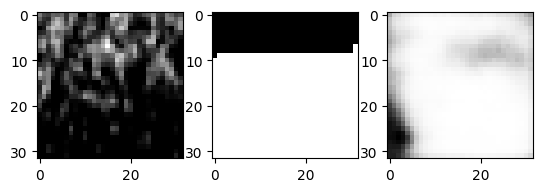

462225.0
1/1 [==============================] - 0s 21ms/step


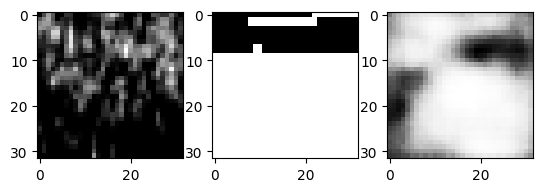

419340.0
1/1 [==============================] - 0s 21ms/step


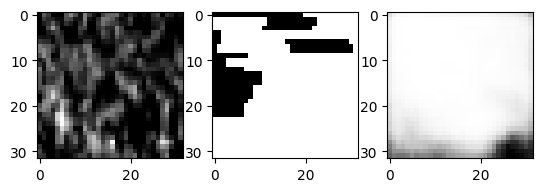

527386.0
1/1 [==============================] - 0s 28ms/step


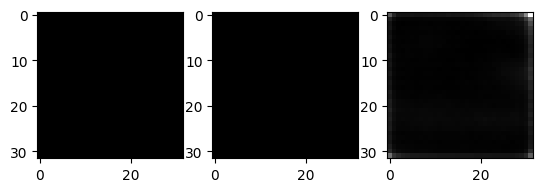

528131.0
1/1 [==============================] - 0s 20ms/step


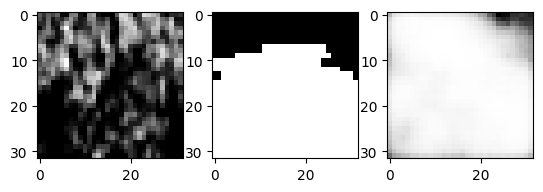

450788.0
1/1 [==============================] - 0s 23ms/step


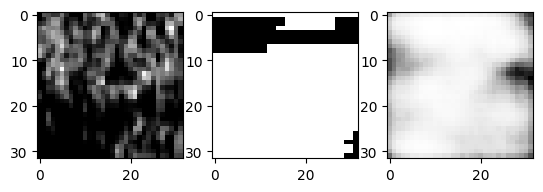

478455.0
1/1 [==============================] - 0s 20ms/step


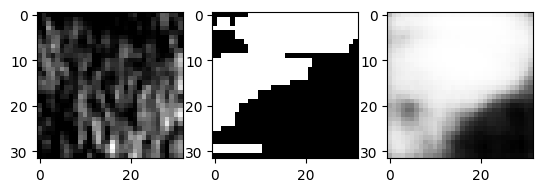

504820.0
1/1 [==============================] - 0s 21ms/step


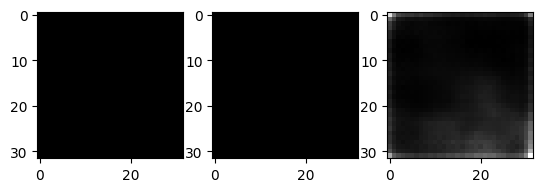

364384.0
1/1 [==============================] - 0s 21ms/step


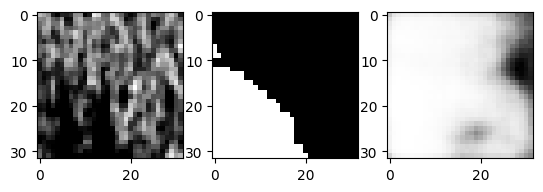

557347.0
1/1 [==============================] - 0s 20ms/step


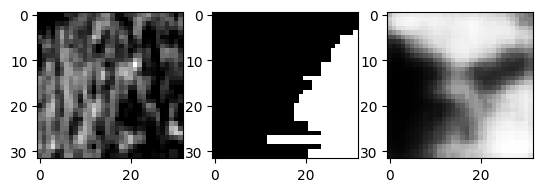

375746.0
1/1 [==============================] - 0s 21ms/step


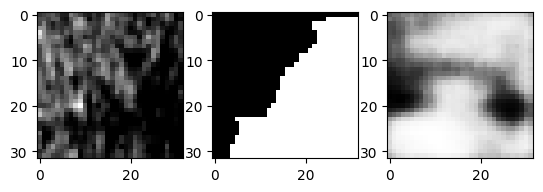

493120.0
1/1 [==============================] - 0s 21ms/step


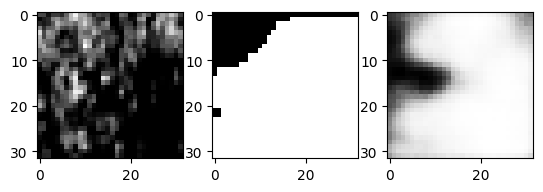

329440.0
1/1 [==============================] - 0s 22ms/step


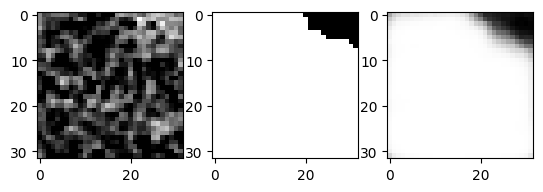

440666.0
1/1 [==============================] - 0s 20ms/step


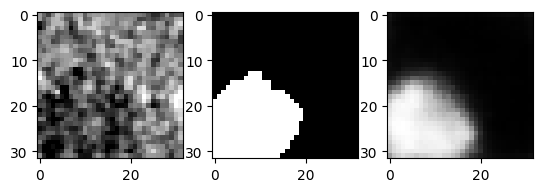

360973.0
1/1 [==============================] - 0s 21ms/step


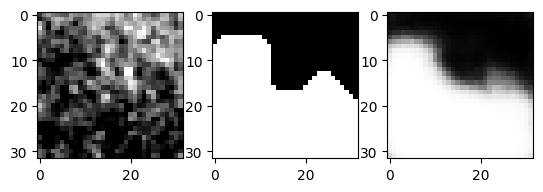

279637.0
1/1 [==============================] - 0s 20ms/step


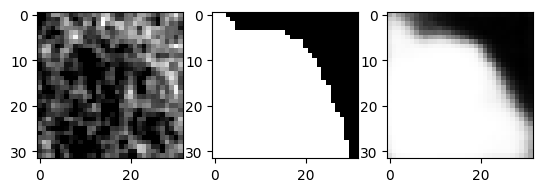

325450.0
1/1 [==============================] - 0s 19ms/step


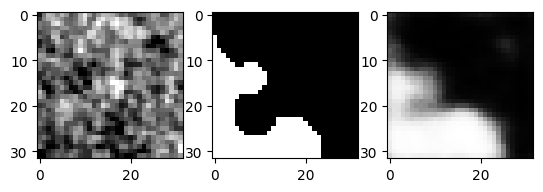

332798.0
1/1 [==============================] - 0s 22ms/step


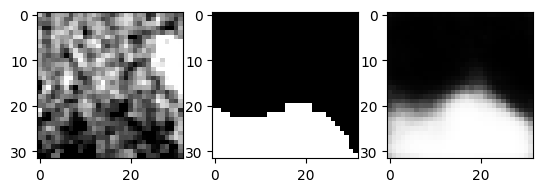

328207.0
1/1 [==============================] - 0s 22ms/step


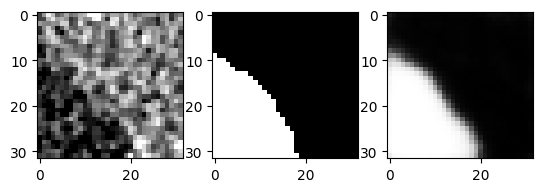

285502.0
1/1 [==============================] - 0s 21ms/step


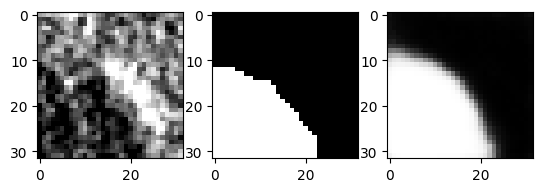

275543.0
1/1 [==============================] - 0s 21ms/step


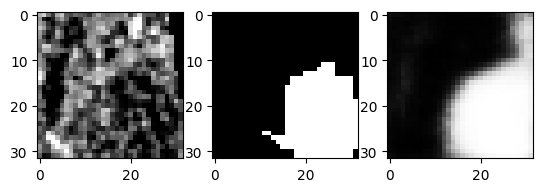

241645.0
1/1 [==============================] - 0s 21ms/step


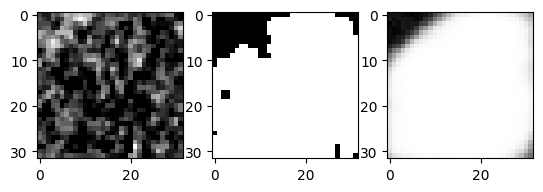

154649.0
1/1 [==============================] - 0s 20ms/step


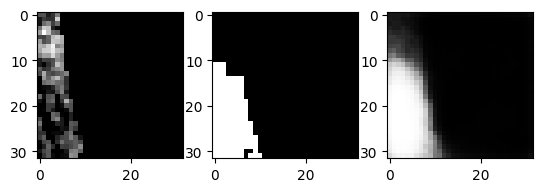

179230.0
1/1 [==============================] - 0s 20ms/step


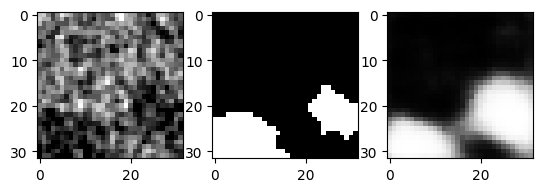

196387.0
1/1 [==============================] - 0s 20ms/step


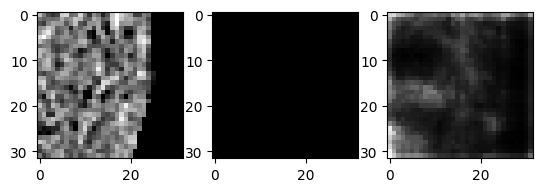

208606.0
1/1 [==============================] - 0s 22ms/step


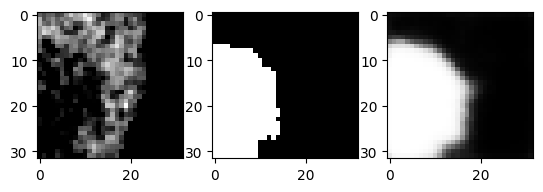

295731.0
1/1 [==============================] - 0s 21ms/step


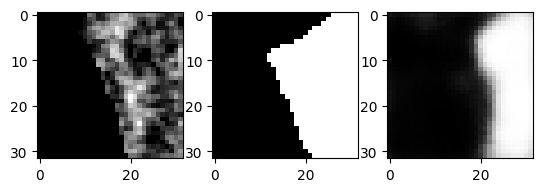

355841.0
1/1 [==============================] - 0s 21ms/step


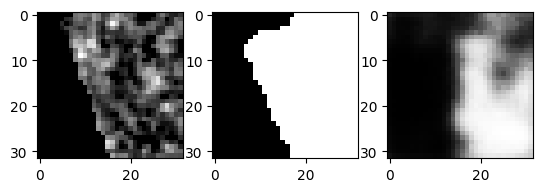

386741.0
1/1 [==============================] - 0s 20ms/step


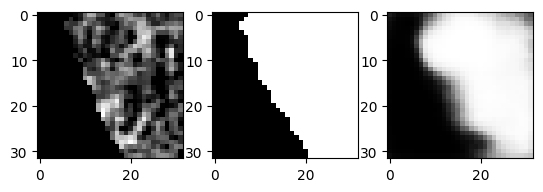

309795.0
1/1 [==============================] - 0s 21ms/step


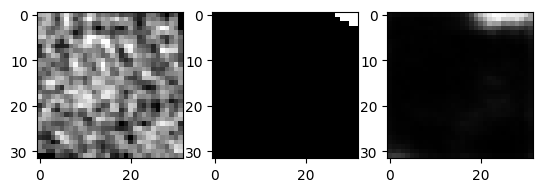

358731.0
1/1 [==============================] - 0s 19ms/step


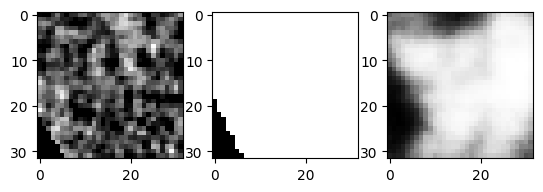

333638.0
1/1 [==============================] - 0s 22ms/step


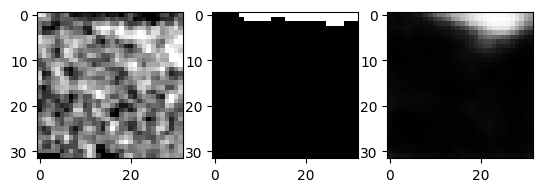

330412.0
1/1 [==============================] - 0s 20ms/step


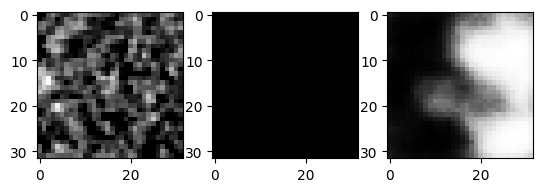

325776.0
1/1 [==============================] - 0s 21ms/step


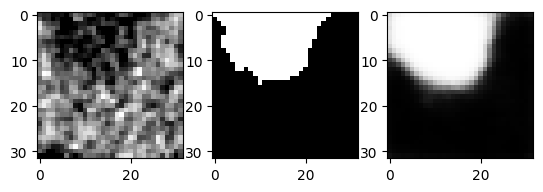

320717.0
1/1 [==============================] - 0s 27ms/step


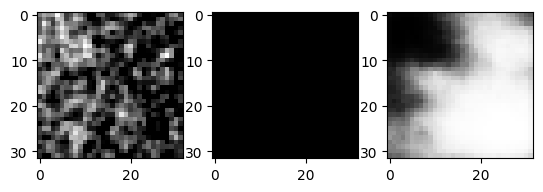

420709.0
1/1 [==============================] - 0s 21ms/step


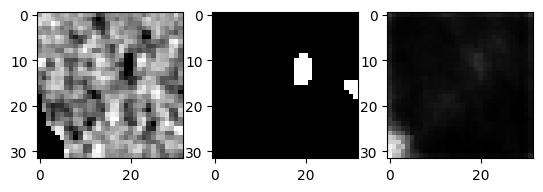

358931.0
1/1 [==============================] - 0s 21ms/step


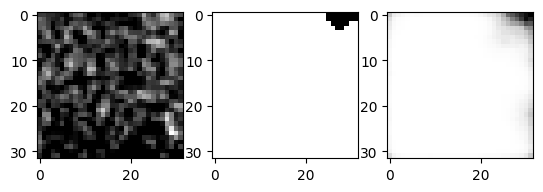

372753.0
1/1 [==============================] - 0s 22ms/step


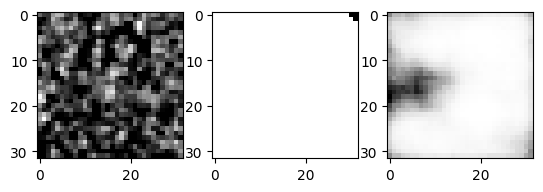

390836.0
1/1 [==============================] - 0s 21ms/step


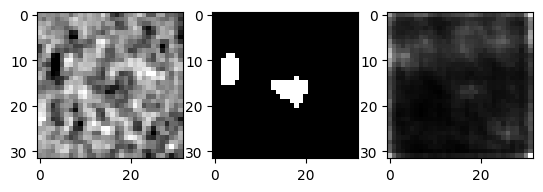

308287.0
1/1 [==============================] - 0s 21ms/step


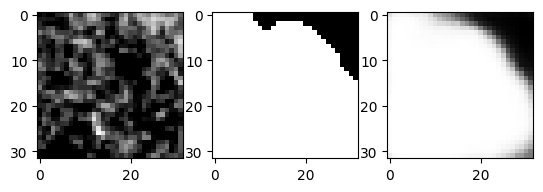

351874.0
1/1 [==============================] - 0s 20ms/step


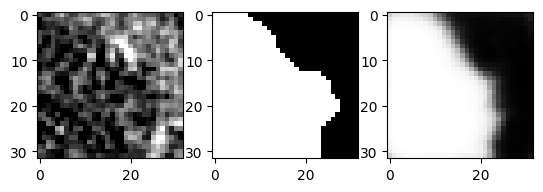

296786.0
1/1 [==============================] - 0s 21ms/step


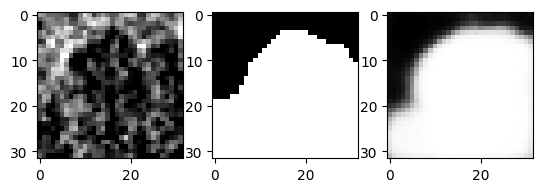

287818.0
1/1 [==============================] - 0s 21ms/step


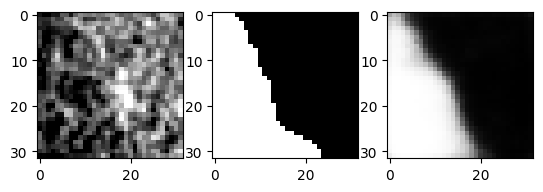

249896.0
1/1 [==============================] - 0s 19ms/step


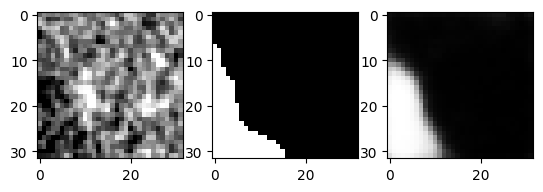

269180.0
1/1 [==============================] - 0s 19ms/step


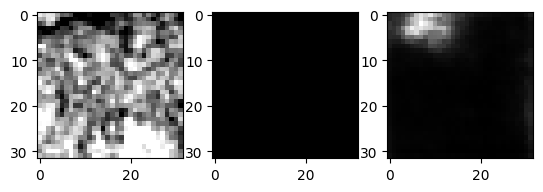

337332.0
1/1 [==============================] - 0s 20ms/step


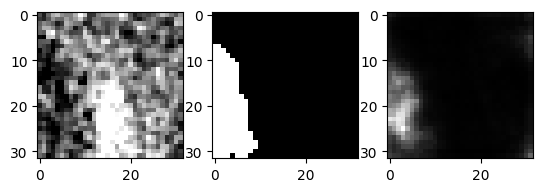

327363.0
1/1 [==============================] - 0s 21ms/step


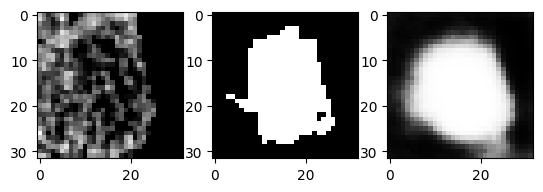

271169.0
1/1 [==============================] - 0s 21ms/step


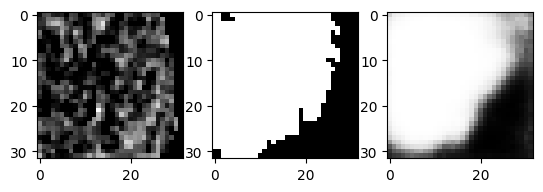

279645.0
1/1 [==============================] - 0s 22ms/step


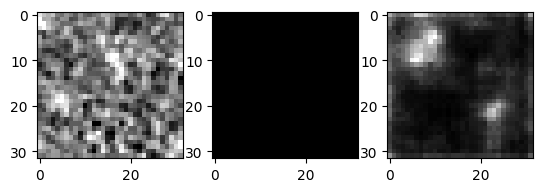

286359.0
1/1 [==============================] - 0s 22ms/step


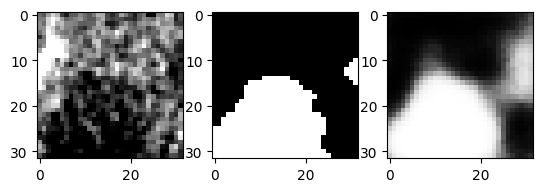

343272.0
1/1 [==============================] - 0s 22ms/step


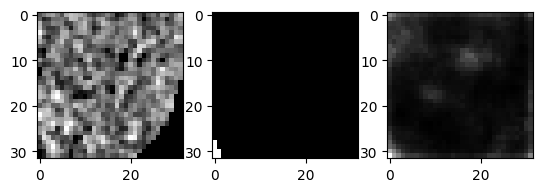

235413.0
1/1 [==============================] - 0s 21ms/step


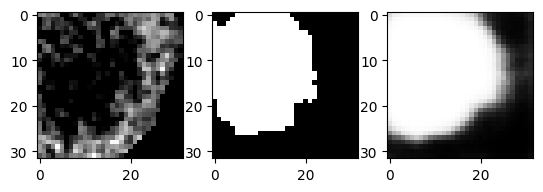

289452.0
1/1 [==============================] - 0s 21ms/step


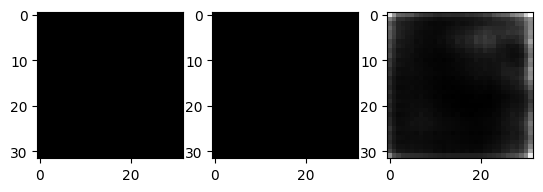

344998.0
1/1 [==============================] - 0s 21ms/step


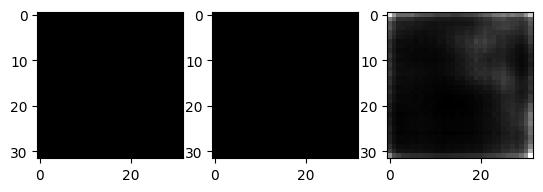

335344.0
1/1 [==============================] - 0s 20ms/step


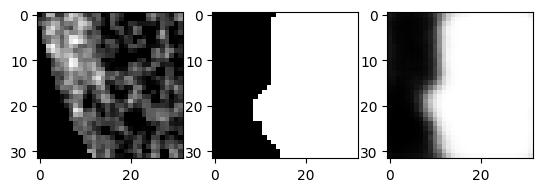

319099.0
1/1 [==============================] - 0s 19ms/step


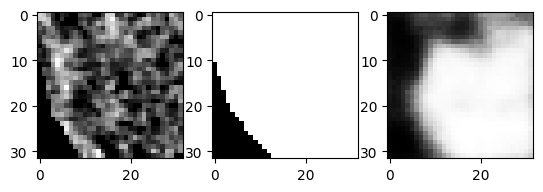

426900.0
1/1 [==============================] - 0s 20ms/step


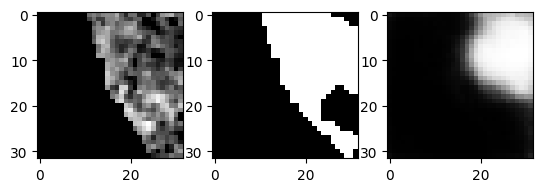

378337.0
1/1 [==============================] - 0s 20ms/step


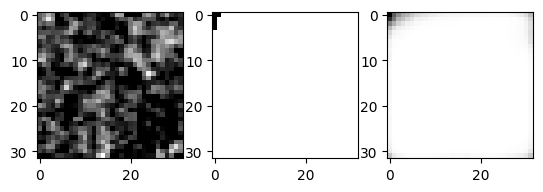

325151.0
1/1 [==============================] - 0s 20ms/step


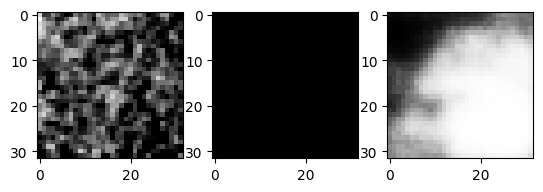

411381.0
1/1 [==============================] - 0s 21ms/step


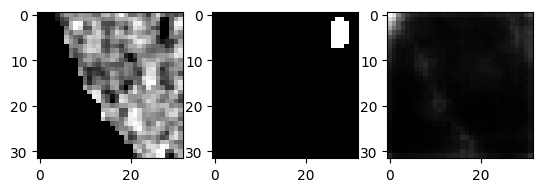

329164.0
1/1 [==============================] - 0s 21ms/step


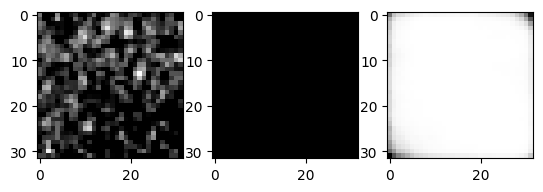

406359.0
1/1 [==============================] - 0s 20ms/step


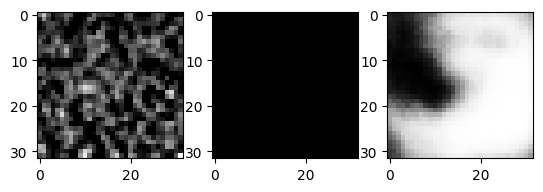

393192.0
1/1 [==============================] - 0s 21ms/step


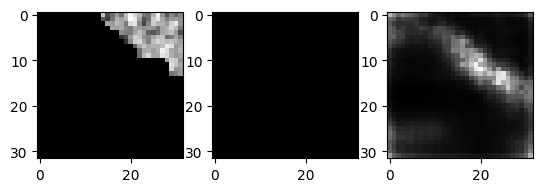

364422.0
1/1 [==============================] - 0s 20ms/step


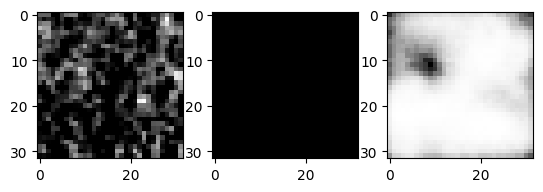

455626.0
1/1 [==============================] - 0s 21ms/step


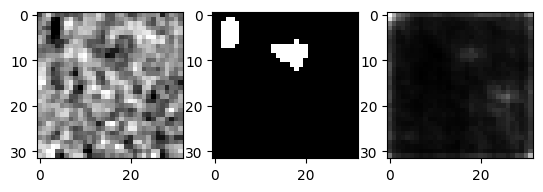

390044.0
1/1 [==============================] - 0s 21ms/step


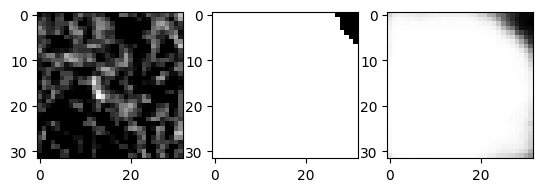

446862.0
1/1 [==============================] - 0s 21ms/step


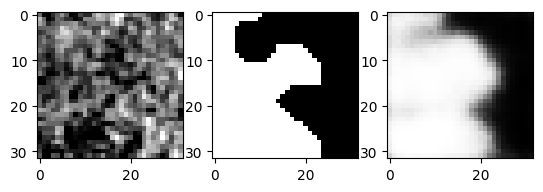

389548.0
1/1 [==============================] - 0s 24ms/step


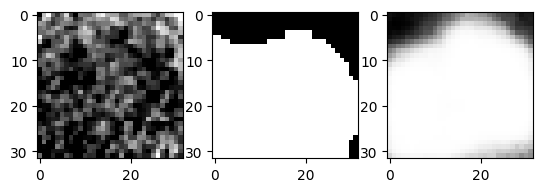

364249.0
1/1 [==============================] - 0s 24ms/step


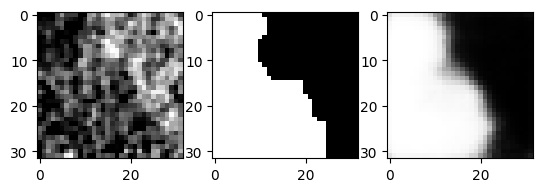

350408.0
1/1 [==============================] - 0s 20ms/step


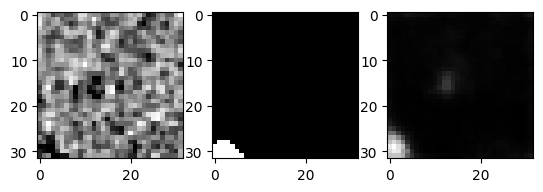

354645.0
1/1 [==============================] - 0s 20ms/step


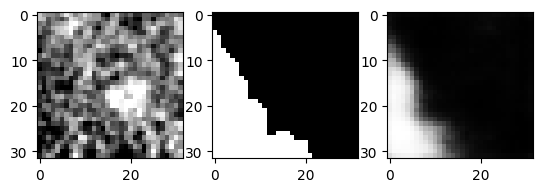

401061.0
1/1 [==============================] - 0s 20ms/step


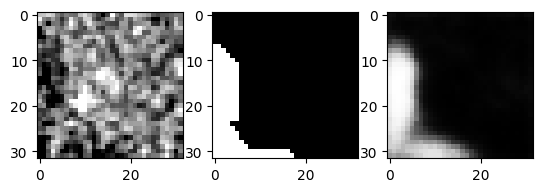

361019.0
1/1 [==============================] - 0s 20ms/step


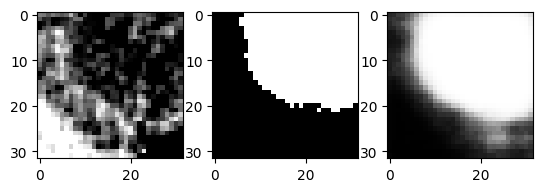

313374.0
1/1 [==============================] - 0s 21ms/step


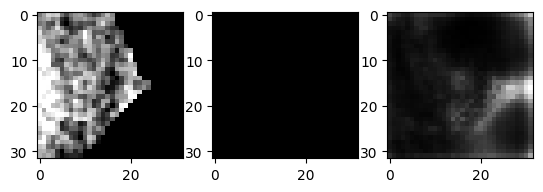

299243.0
1/1 [==============================] - 0s 21ms/step


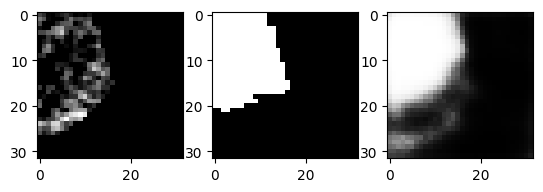

314705.0
1/1 [==============================] - 0s 21ms/step


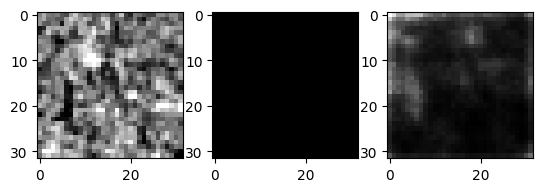

359615.0
1/1 [==============================] - 0s 21ms/step


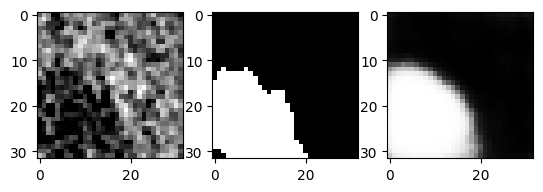

355283.0
1/1 [==============================] - 0s 21ms/step


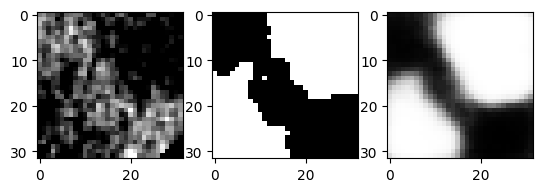

399491.0
1/1 [==============================] - 0s 21ms/step


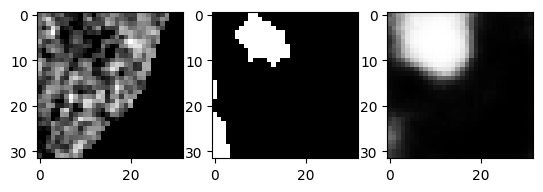

426438.0
1/1 [==============================] - 0s 21ms/step


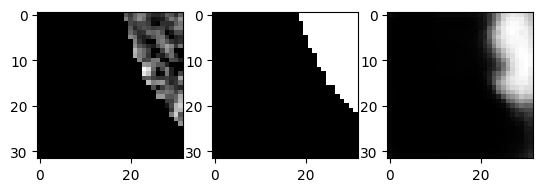

440716.0
1/1 [==============================] - 0s 20ms/step


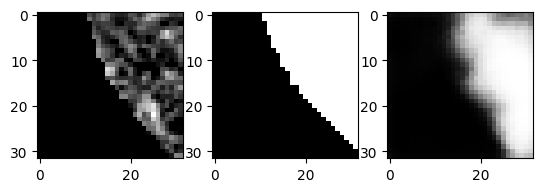

509881.0
1/1 [==============================] - 0s 20ms/step


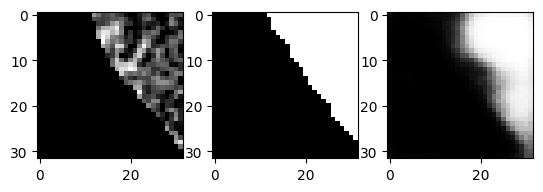

506599.0
1/1 [==============================] - 0s 21ms/step


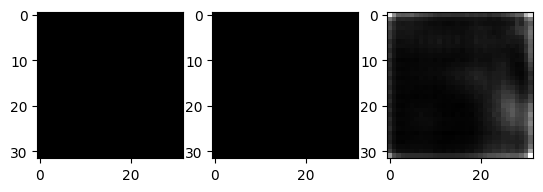

519982.0
1/1 [==============================] - 0s 21ms/step


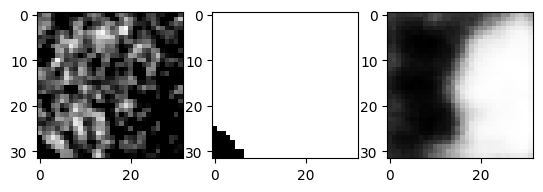

611343.0
1/1 [==============================] - 0s 21ms/step


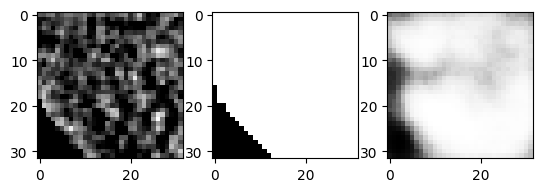

665926.0
1/1 [==============================] - 0s 21ms/step


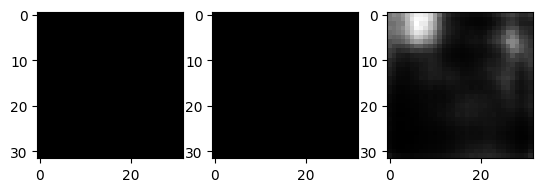

677767.0
1/1 [==============================] - 0s 25ms/step


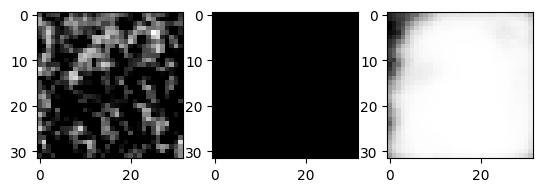

679877.0
1/1 [==============================] - 0s 23ms/step


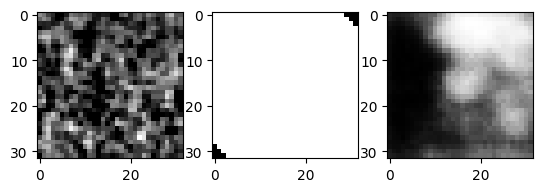

590423.0
1/1 [==============================] - 0s 24ms/step


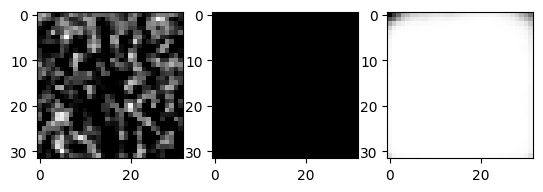

453207.0
1/1 [==============================] - 0s 22ms/step


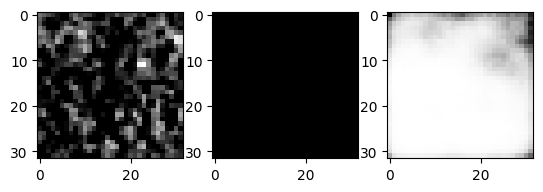

495345.0
1/1 [==============================] - 0s 21ms/step


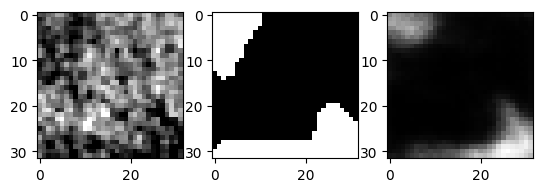

442601.0
1/1 [==============================] - 0s 21ms/step


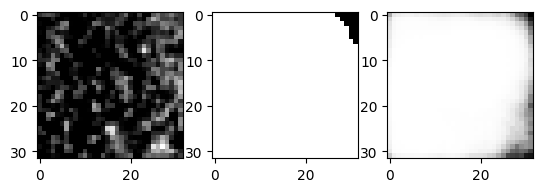

512675.0
1/1 [==============================] - 0s 22ms/step


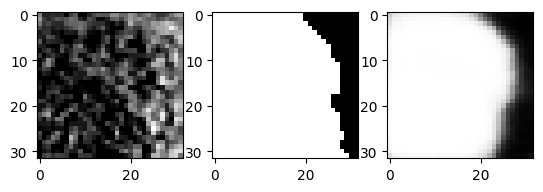

492575.0
1/1 [==============================] - 0s 20ms/step


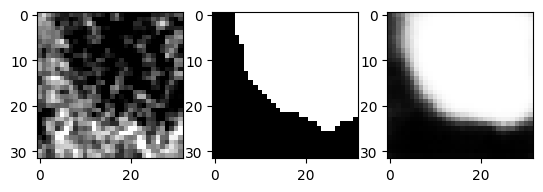

478797.0
1/1 [==============================] - 0s 27ms/step


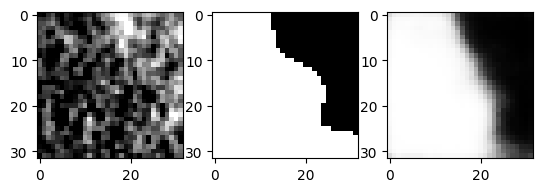

421576.0
1/1 [==============================] - 0s 21ms/step


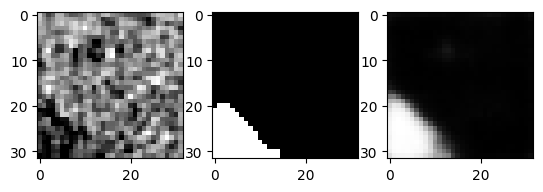

327828.0
1/1 [==============================] - 0s 19ms/step


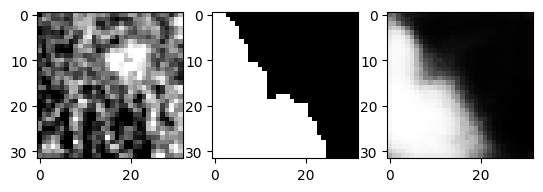

358704.0
1/1 [==============================] - 0s 21ms/step


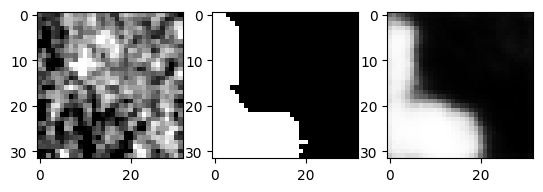

334854.0
1/1 [==============================] - 0s 20ms/step


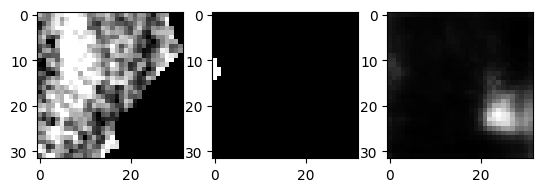

314540.0
1/1 [==============================] - 0s 21ms/step


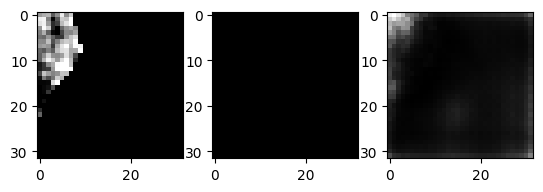

332259.0
1/1 [==============================] - 0s 20ms/step


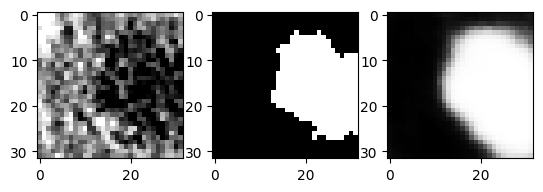

382008.0
1/1 [==============================] - 0s 21ms/step


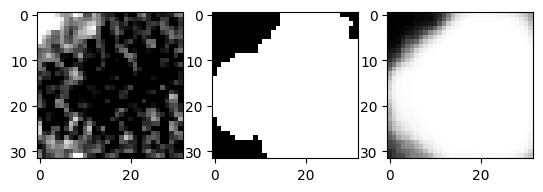

449917.0
1/1 [==============================] - 0s 20ms/step


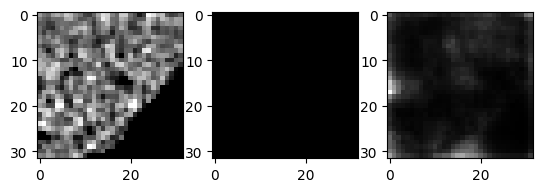

400710.0
1/1 [==============================] - 0s 20ms/step


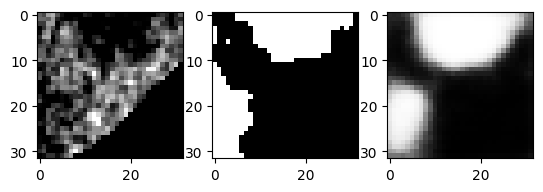

519176.0
1/1 [==============================] - 0s 23ms/step


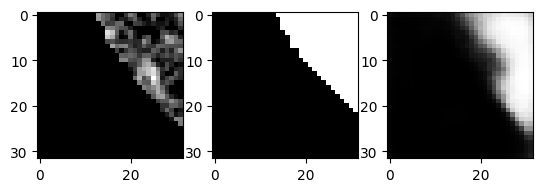

541381.0
1/1 [==============================] - 0s 22ms/step


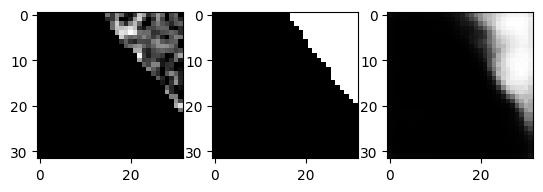

625063.0
1/1 [==============================] - 0s 20ms/step


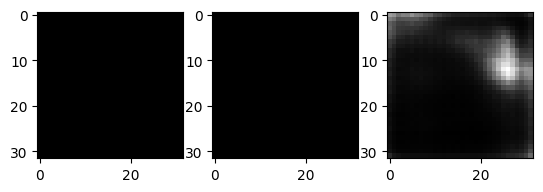

483539.0
1/1 [==============================] - 0s 26ms/step


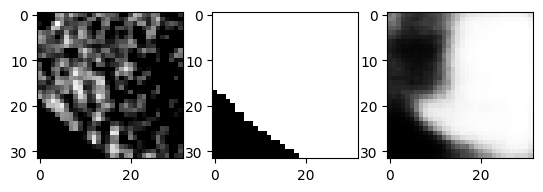

579976.0
1/1 [==============================] - 0s 25ms/step


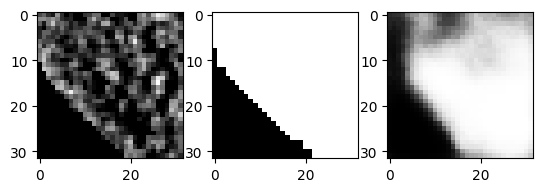

526265.0
1/1 [==============================] - 0s 23ms/step


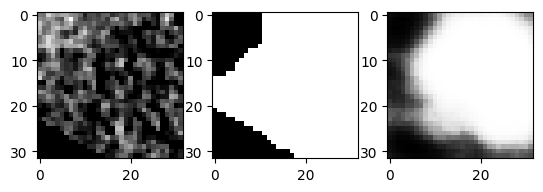

487881.0
1/1 [==============================] - 0s 21ms/step


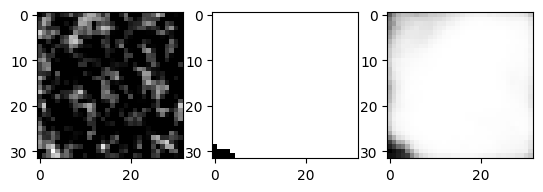

529485.0
1/1 [==============================] - 0s 21ms/step


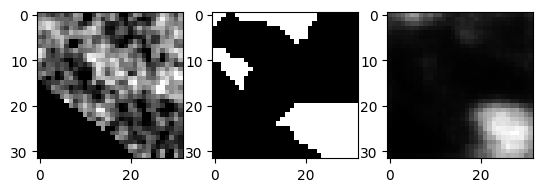

414631.0
1/1 [==============================] - 0s 22ms/step


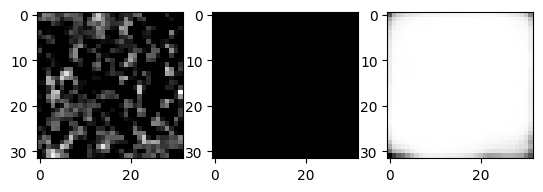

491716.0
1/1 [==============================] - 0s 21ms/step


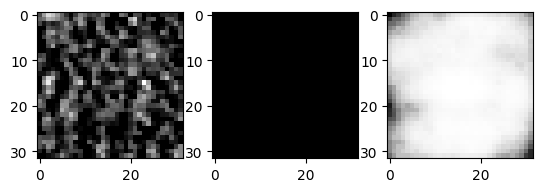

485400.0
1/1 [==============================] - 0s 22ms/step


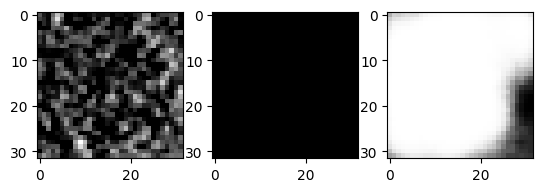

550052.0
1/1 [==============================] - 0s 20ms/step


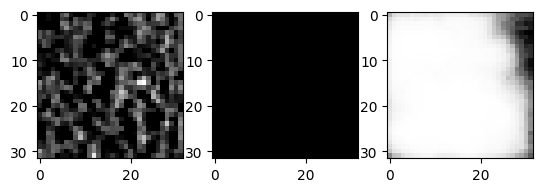

539078.0
1/1 [==============================] - 0s 22ms/step


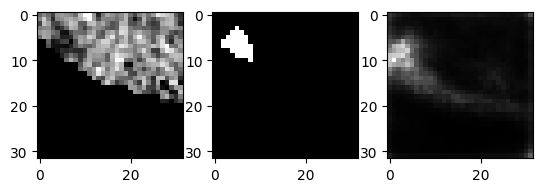

421032.0
1/1 [==============================] - 0s 20ms/step


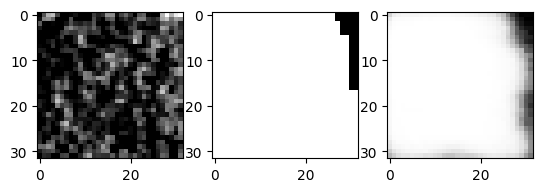

534841.0
1/1 [==============================] - 0s 21ms/step


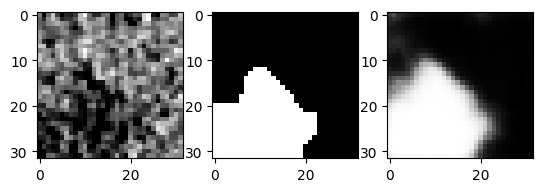

410578.0
1/1 [==============================] - 0s 21ms/step


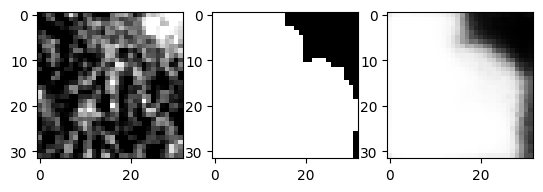

472696.0
1/1 [==============================] - 0s 22ms/step


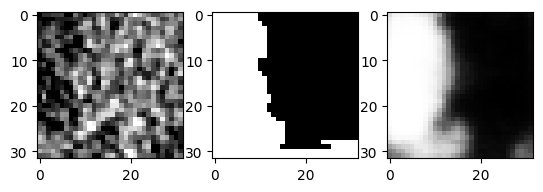

408357.0
1/1 [==============================] - 0s 22ms/step


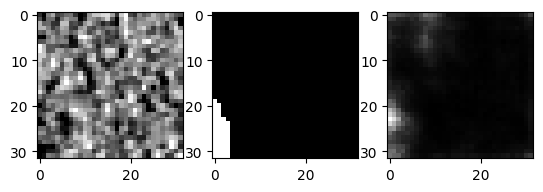

421193.0
1/1 [==============================] - 0s 21ms/step


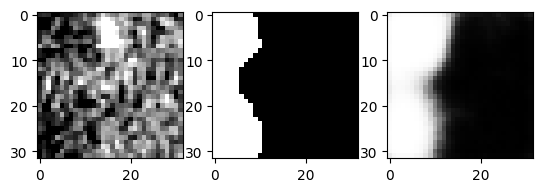

275420.0
1/1 [==============================] - 0s 20ms/step


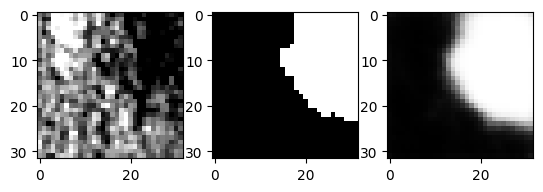

443001.0
1/1 [==============================] - 0s 20ms/step


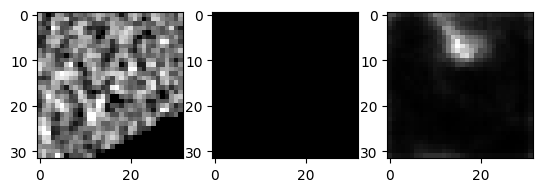

336034.0
1/1 [==============================] - 0s 22ms/step


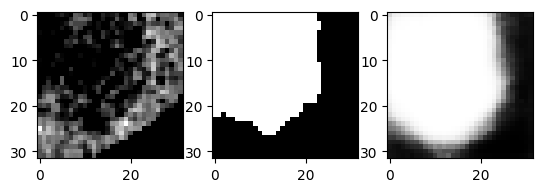

495598.0
1/1 [==============================] - 0s 22ms/step


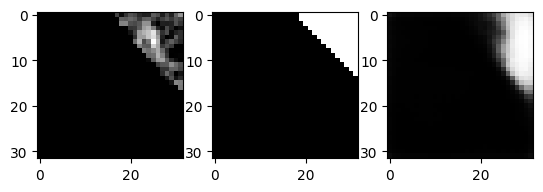

455854.0
1/1 [==============================] - 0s 21ms/step


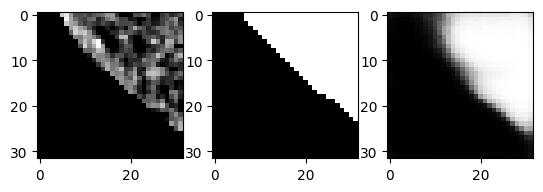

520538.0
1/1 [==============================] - 0s 20ms/step


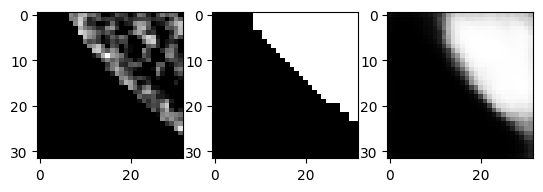

547698.0
1/1 [==============================] - 0s 22ms/step


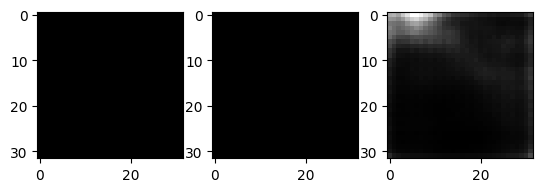

526047.0
1/1 [==============================] - 0s 21ms/step


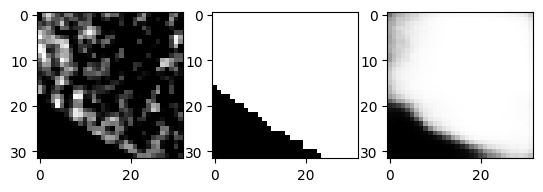

647812.0
1/1 [==============================] - 0s 20ms/step


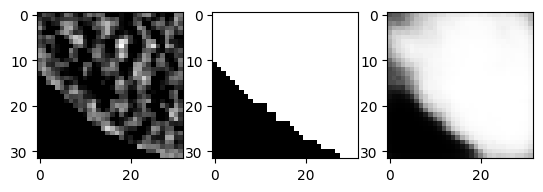

565774.0
1/1 [==============================] - 0s 21ms/step


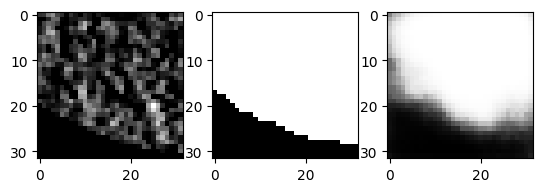

540016.0
1/1 [==============================] - 0s 21ms/step


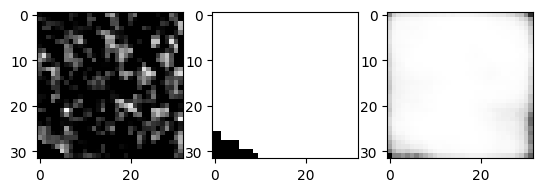

595376.0
1/1 [==============================] - 0s 20ms/step


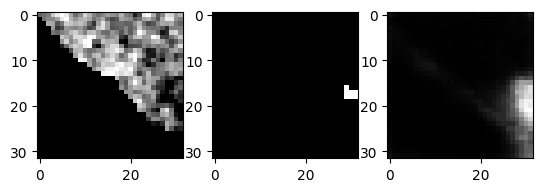

411828.0
1/1 [==============================] - 0s 20ms/step


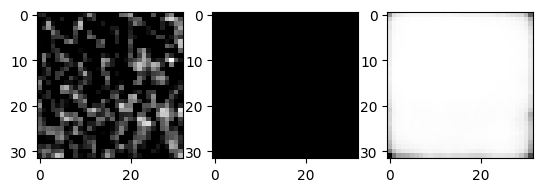

507010.0
1/1 [==============================] - 0s 20ms/step


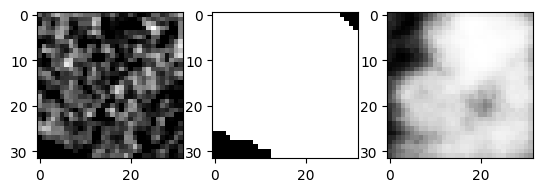

409105.0
1/1 [==============================] - 0s 20ms/step


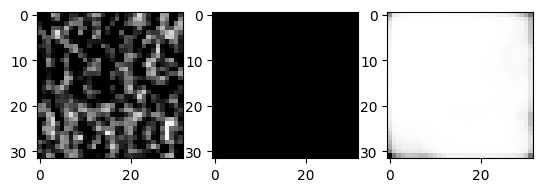

409061.0
1/1 [==============================] - 0s 18ms/step


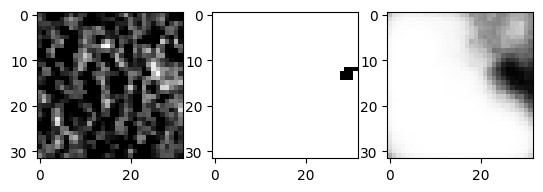

454473.0
1/1 [==============================] - 0s 20ms/step


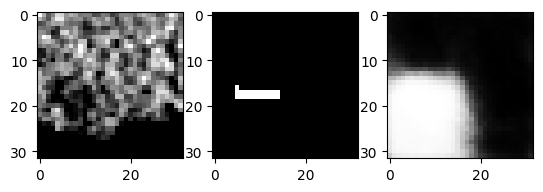

488220.0
1/1 [==============================] - 0s 20ms/step


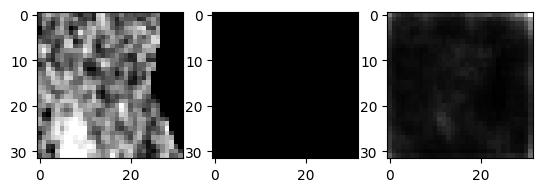

582720.0
1/1 [==============================] - 0s 20ms/step


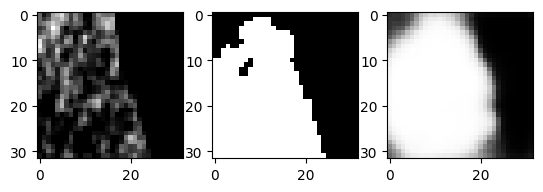

459562.0
1/1 [==============================] - 0s 20ms/step


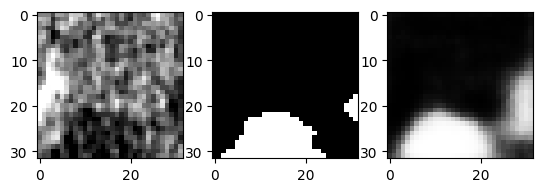

629341.0
1/1 [==============================] - 0s 19ms/step


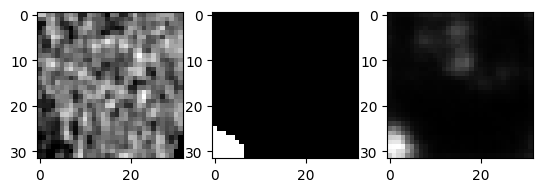

506415.0
1/1 [==============================] - 0s 18ms/step


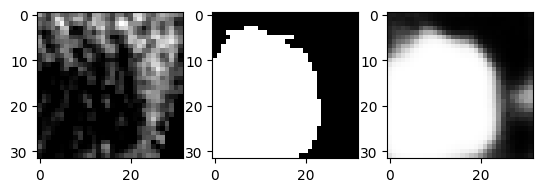

567619.0
1/1 [==============================] - 0s 25ms/step


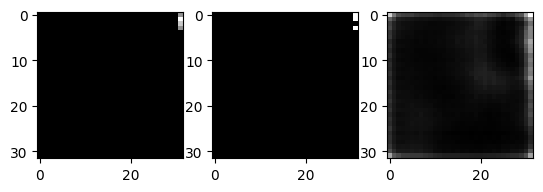

646190.0
1/1 [==============================] - 0s 21ms/step


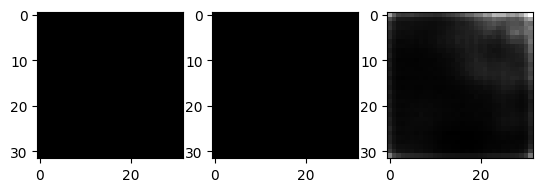

561911.0
1/1 [==============================] - 0s 20ms/step


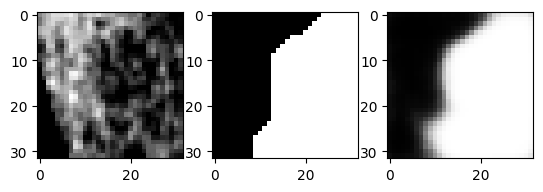

534597.0
1/1 [==============================] - 0s 20ms/step


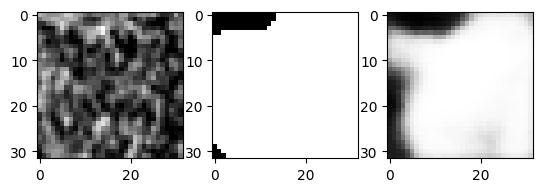

548708.0
1/1 [==============================] - 0s 20ms/step


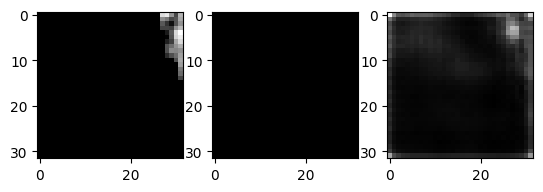

522458.0
1/1 [==============================] - 0s 22ms/step


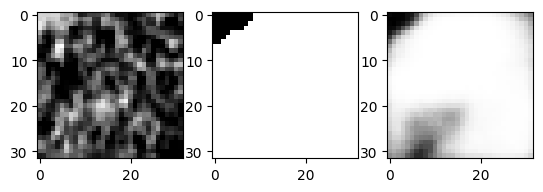

681515.0
1/1 [==============================] - 0s 22ms/step


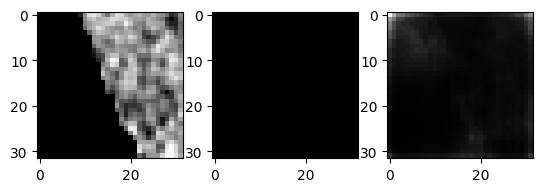

517980.0
1/1 [==============================] - 0s 20ms/step


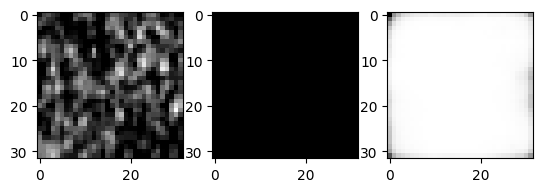

In [15]:
for sample in valid_dataset.take(1000):
    print(np.sum(sample[1]))
    if np.sum(sample[1]) > 50:
        presd = model.predict(sample[0])
        plt.subplot(1,3,1)
        plt.imshow(sample[0][0,:,:,0],cmap='gray')
        plt.subplot(1,3,2)
        plt.imshow(sample[1][0,:,:,0],cmap='gray')
        plt.subplot(1,3,3)
        plt.imshow(presd[0,:,:,0],cmap='gray')
        plt.show()
    